In [51]:
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\ahmad\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['std', 'mean', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Imports

In [120]:
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import time
import copy
import scipy.stats


# Models


## Attention Layer


In [53]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

## RNN


In [54]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = torch.tanh(out)
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## RNN With Attention then Expansion


In [55]:
class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)
        print(attn_out.shape)
        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        print(expanded_attn_out.shape)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # RNN processing
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(expanded_attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # RNN processing
                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


In [ ]:
model = NetRNNWithAttention()
print(model)
print(model(torch.Tensor(np.random.random((1,30,3)))))

## RNN Expansion first then Attention


In [56]:
class NetRNNWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # RNN layer
        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # RNN processing
        h0 = torch.zeros(1, attn_out.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # RNN processing
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetRNNWithAttention(hidden_dim=12)


## LSTM


In [57]:
class NetLSTM(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # Initialize hidden and cell states
        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
                   torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        # LSTM processing
        out, self.h0 = self.lstmLayer(x, self.h0)
        out = torch.tanh(out)  # Apply tanh to the LSTM output if needed

        # Concatenate hidden and cell states
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = torch.tanh(out)  # Apply tanh to the LSTM output if needed
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    
model = NetLSTM(hidden_dim=12)


## LSTM with Attention then Expansion


In [58]:
class NetLSTMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        lstm_out, _ = self.lstmLayer(expanded_attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # LSTM processing
                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetLSTMWithAttention(hidden_dim=12)


## LSTM Expansion first then Attention


In [9]:
class NetLSTMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim / 2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim / 2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)))
        lstm_out, _ = self.lstmLayer(attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim / 2)),
                  torch.zeros(1, 1, int(self.hidden_dim / 2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # LSTM processing
                out, h0 = self.lstmLayer(attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetLSTMWithAttention(hidden_dim=12)


## GRU


In [59]:
class NetGRU(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(x, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                # GRU processing
                out, h0 = self.gruLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetGRU(hidden_dim=12)


## GRU with Attention then Expansion


In [60]:
class NetGRUMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # GRU processing
                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


## GRU Expansion first then Attention


In [ ]:
class NetGRUMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # GRU processing
                out, h0 = self.gruLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


# Data Generation


In [61]:
def generateTrainData(num_samples, min_max):
    s = []  # Sequences
    t = []  # Labels
    params = {
    "min_length": min_max[0],
    "max_length": min_max[1],
    "fill": 0,
    "value_1": -1,
    "value_2": 1,
}
    for _ in range(num_samples):
        common_length = np.random.randint(params["min_length"], params["max_length"] + 1)

        array_A = np.full(common_length, params["fill"])
        array_B = np.full(common_length, params["fill"])
        array_C = np.full(common_length, params["fill"])

        # Exclude the last two indices
        possible_indices = np.arange(common_length - 2)

        index_A = np.random.choice(possible_indices)
        value_A = np.random.choice([params["value_1"], params["value_2"]])
        array_A[index_A] = value_A

        # Update possible indices for array B to also exclude index_A
        possible_indices_B = np.delete(possible_indices, np.where(possible_indices == index_A))
        index_B = np.random.choice(possible_indices_B)
        value_B = np.random.choice([params["value_1"], params["value_2"]])
        array_B[index_B] = value_B

        value_C = np.random.choice([params["value_1"], params["value_2"]])
        array_C[-1] = value_C
        array_C[-2] = value_C

        mapped_value_A = 1 if value_A == params["value_2"] else 0
        mapped_value_B = 1 if value_B == params["value_2"] else 0
        #value_1 = -1
        #value_2 = 1
        if value_C == params["value_1"]: # XOR
            result = int(mapped_value_A != mapped_value_B) 
        else : # XNOR
            result =  int(mapped_value_A == mapped_value_B)

        # Mapping back to original value_1 and value_2 for the label
        label_value_A = params["value_2"] if mapped_value_A == 1 else params["value_1"]
        label_value_B = params["value_2"] if mapped_value_B == 1 else params["value_1"]
        results_XORNOR= params["value_2"] if result == 1 else params["value_1"]

        #label_arr = [mapped_value_A, mapped_value_B, result]  # Label array with value_A, value_B, and result
        label_arr = [label_value_A, label_value_B, results_XORNOR]  # Label array with value_A, value_B, and result

        combined_array = np.vstack([array_A, array_B, array_C]).T
        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)


In [ ]:
num_seq = 1
# Example dictionary with parameters
sequences, labels = generateTrainData(num_seq, [5,5])
print(sequences)
print(labels)

In [ ]:

sequences, labels = generateTrainData(1, [10,10])
model = NetRNN()
output=model(torch.Tensor(sequences))
print(torch.Tensor(sequences))
print(output.shape)
print(model)

In [ ]:
sequences, labels = generateTrainData(5, [10,15])

def plot_sequences(sequences, labels):
    num_samples = len(sequences)  # Number of samples to display

    # Plotting
    plt.figure(figsize=(3 * num_samples, 15))

    for i, (seq, label) in enumerate(zip(sequences, labels)):
        reshaped_sequence = seq  # Use the sequence as it is

        ax = plt.subplot(1, num_samples, i + 1)
        img = ax.imshow(
            reshaped_sequence, cmap="gray", vmin=-1.0, vmax=1.0
        )  # Adjusted vmin and vmax
        operation_title = "XOR" if seq[-1][2] == -1 else "XNOR"
        ax.set_title(f"Operation: {operation_title}, {label}")

        ax.set_xlabel("Arrays (A, B, C)")
        ax.set_ylabel("Time Points")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["A", "B", "C"])
        ax.set_yticks(range(reshaped_sequence.shape[0]))
        ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

    # Adjusted positioning of colorbar
    cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(img, cax=cbar_ax)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(["-1", "0", "1"])

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


# Example usage
# Assuming sequences and labels are already generated using generateTrainData
plot_sequences(sequences, labels)

In [ ]:
parameters_list = []

# min_lengths = [5, 10, 10, 20, 20, 40, 40, 70,100]
# max_lengths = [5, 10, 15, 20, 25, 40, 45,75,140]
min_lengths = [10]
max_lengths = [10]

# Training


In [ ]:
collectorA = dict()
num_samples = 100
for rep in range(3):  # Number of repetitions
    for min_len, max_len in zip(min_lengths, max_lengths):
        # Select the model based on 'kind'
        for kind in ["RNN", "RNNA", "RNNE","LSTM", "LSTMA","LSTME", "GRU", "GRUA","GRUE"]:
        # Select the model based on 'kind'
            if kind == "RNN":
                model = NetRNN(hidden_dim=12, inp=3)
            elif kind == "RNNA":
                model = NetRNNWithAttention(hidden_dim=12, inp=3)
            elif kind == "RNNE":
                model = NetRNNWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "LSTM":
                model = NetLSTM(hidden_dim=12, inp=3)
            elif kind == "LSTMA":
                model = NetLSTMWithAttention(hidden_dim=12, inp=3)
            elif kind == "LSTME":
                model = NetLSTMWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "GRU":
                model = NetGRU(hidden_dim=12, inp=3)
            elif kind == "GRUA":
                model = NetGRUMWithAttention(hidden_dim=12, inp=3)
            elif kind == "GRUE":
                model = NetGRUMWithAttentionExpFirst(hidden_dim=12, inp=3)

            optimizer = optim.Adam(model.parameters())
            criterion = nn.MSELoss()
            acc = 0.0
            W = []
            AC = []
            start_time = time.time()  # Start time of the epoch

            while True:
                sequences, targets = generateTrainData(num_samples, [min_len,max_len])
                total_loss = 0
                total_acc = 0
                count = 0

                for seq, target in zip(sequences, targets):
                    optimizer.zero_grad()
                    seq_tensor = torch.Tensor([seq])  # Add an extra dimension for batch
                    target_tensor = torch.Tensor([target])

                    output = model(seq_tensor)
                    loss = criterion(output, target_tensor)
                    total_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                    # Calculate accuracy
                    A = 1.0 * (target_tensor.detach() > 0.0)
                    B = 1.0 * (output.detach() > 0.0)
                    acc = (1.0 * (A.flatten() == B.flatten())).mean()
                    total_acc += acc
                    count += 1

                avg_loss = total_loss / count
                avg_acc = total_acc / count
                W.append(avg_loss)
                AC.append(avg_acc)
                print(f"{kind}, rep: {rep}, epoch: {len(AC)}, acc: {avg_acc}, Loss {avg_loss}")

                # Check for stopping condition
                if avg_acc >= 0.97 or len(W)>2000:
                    break

                end_time = time.time()  # End time of the epoch
                epoch_duration = end_time - start_time  # Calculate duration
                collectorA[f"{kind}_rep_{rep}_min_{min_len} max_{max_len}"] = AC
                torch.save(model, f'model_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.model')
                print(f"{kind:<20} Rep: {rep:<3} Epoch: {len(A):<5} Acc: {avg_acc:.4f} " f"_min_{min_len}_max_{max_len} Time: {epoch_duration:.2f} sec")
                df=pd.DataFrame()
                df["accuracy"]=AC
                df["loss"]=W
                df.to_csv(f'score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv')

In [ ]:
print(collectorA.keys())

# Accuracy plots


In [138]:
def tensor_str_to_float(tensor_str):
    # Convert a string like 'tensor(0.4533)' to a float
    return float(tensor_str.strip('tensor()'))

def pad_data(data, target_length):
    # Truncate or extend the data to the target length
    if len(data) > target_length:
        return data[:target_length]
    else:
        pad_value = data[-1] if data else 0  # Use last value or 0 if data is empty
        x = data + [pad_value] * (target_length - len(data))
        return x[:target_length]
    
    
    
def read_and_process_csv(filename, target_epoch, process_func, skip_condition=None):
    try:
        data = pd.read_csv(filename)
        data['accuracy'] = data['accuracy'].apply(process_func)

        if skip_condition and skip_condition(data):
            return None, True

        padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
        return padded_data, False
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None, False

def skip_condition(data):
    return len(data) >= 2000 and data['accuracy'].max() < 0.97


# Function to find the first epoch where accuracy reaches 80%
def find_epoch_at_80_percent(accuracy_list):  
    for i, acc in enumerate(accuracy_list):
        if acc >= 0.80:
            return i
    return None

In [139]:
import pandas as pd

# Your parameters
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
accuracy_threshold = 0.97


# Finding models that meet criteria
models_below_threshold = []

for kind in kinds:
    for min_len, max_len in zip(min_lengths, max_lengths):
        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            
            try:
                data = pd.read_csv(filename)
                epochs = len(data)
                accuracy = data['accuracy'].apply(tensor_str_to_float)

                if epochs >= target_epoch and accuracy.max() < accuracy_threshold:
                    models_below_threshold.append({
                        'Kind': kind,
                        'Min_Length': min_len,
                        'Max_Length': max_len,
                        'Replicate': rep,
                        'Max_Accuracy': accuracy.max(),
                        'Epochs': epochs
                    })
            except FileNotFoundError:
                print(f"File not found: {filename}")

# Displaying models that meet criteria
for model in models_below_threshold:
    print(model)


{'Kind': 'RNN', 'Min_Length': 50, 'Max_Length': 50, 'Replicate': 2, 'Max_Accuracy': 0.9067, 'Epochs': 2001}
{'Kind': 'RNN', 'Min_Length': 50, 'Max_Length': 50, 'Replicate': 25, 'Max_Accuracy': 0.7133, 'Epochs': 2001}


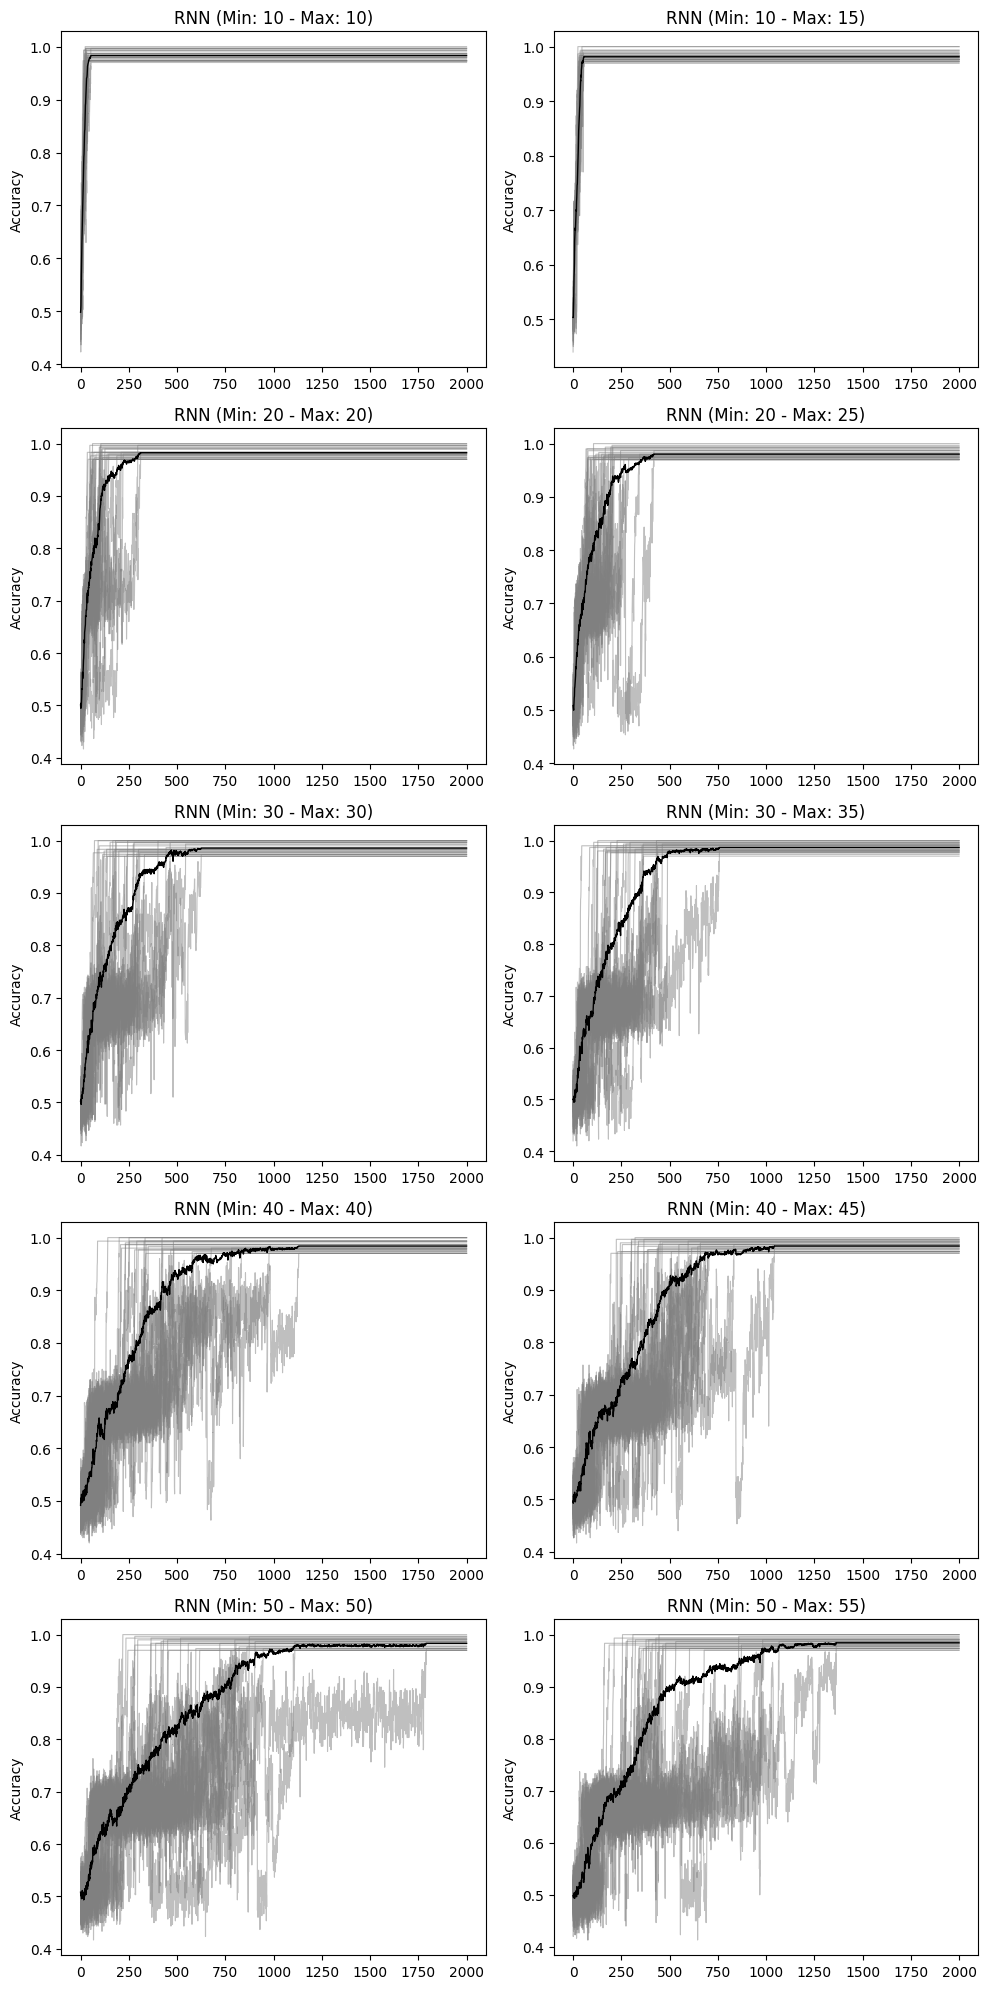

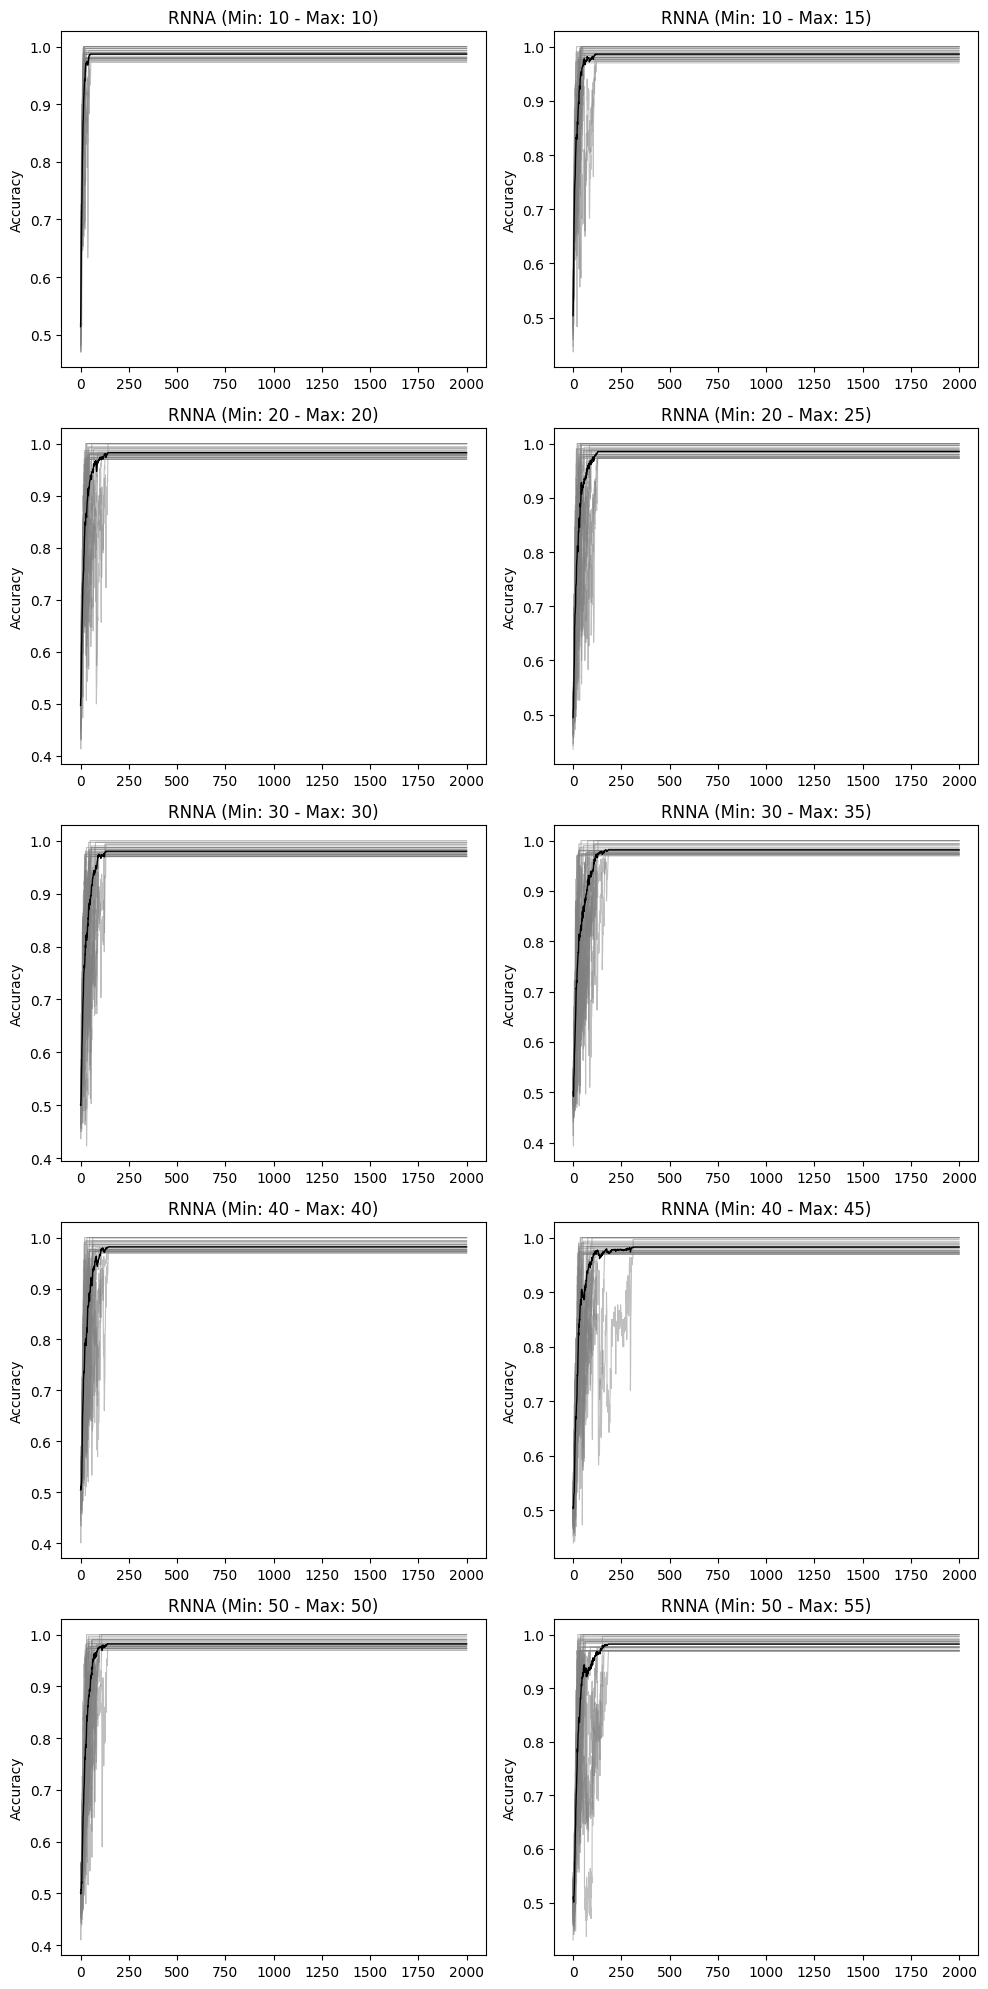

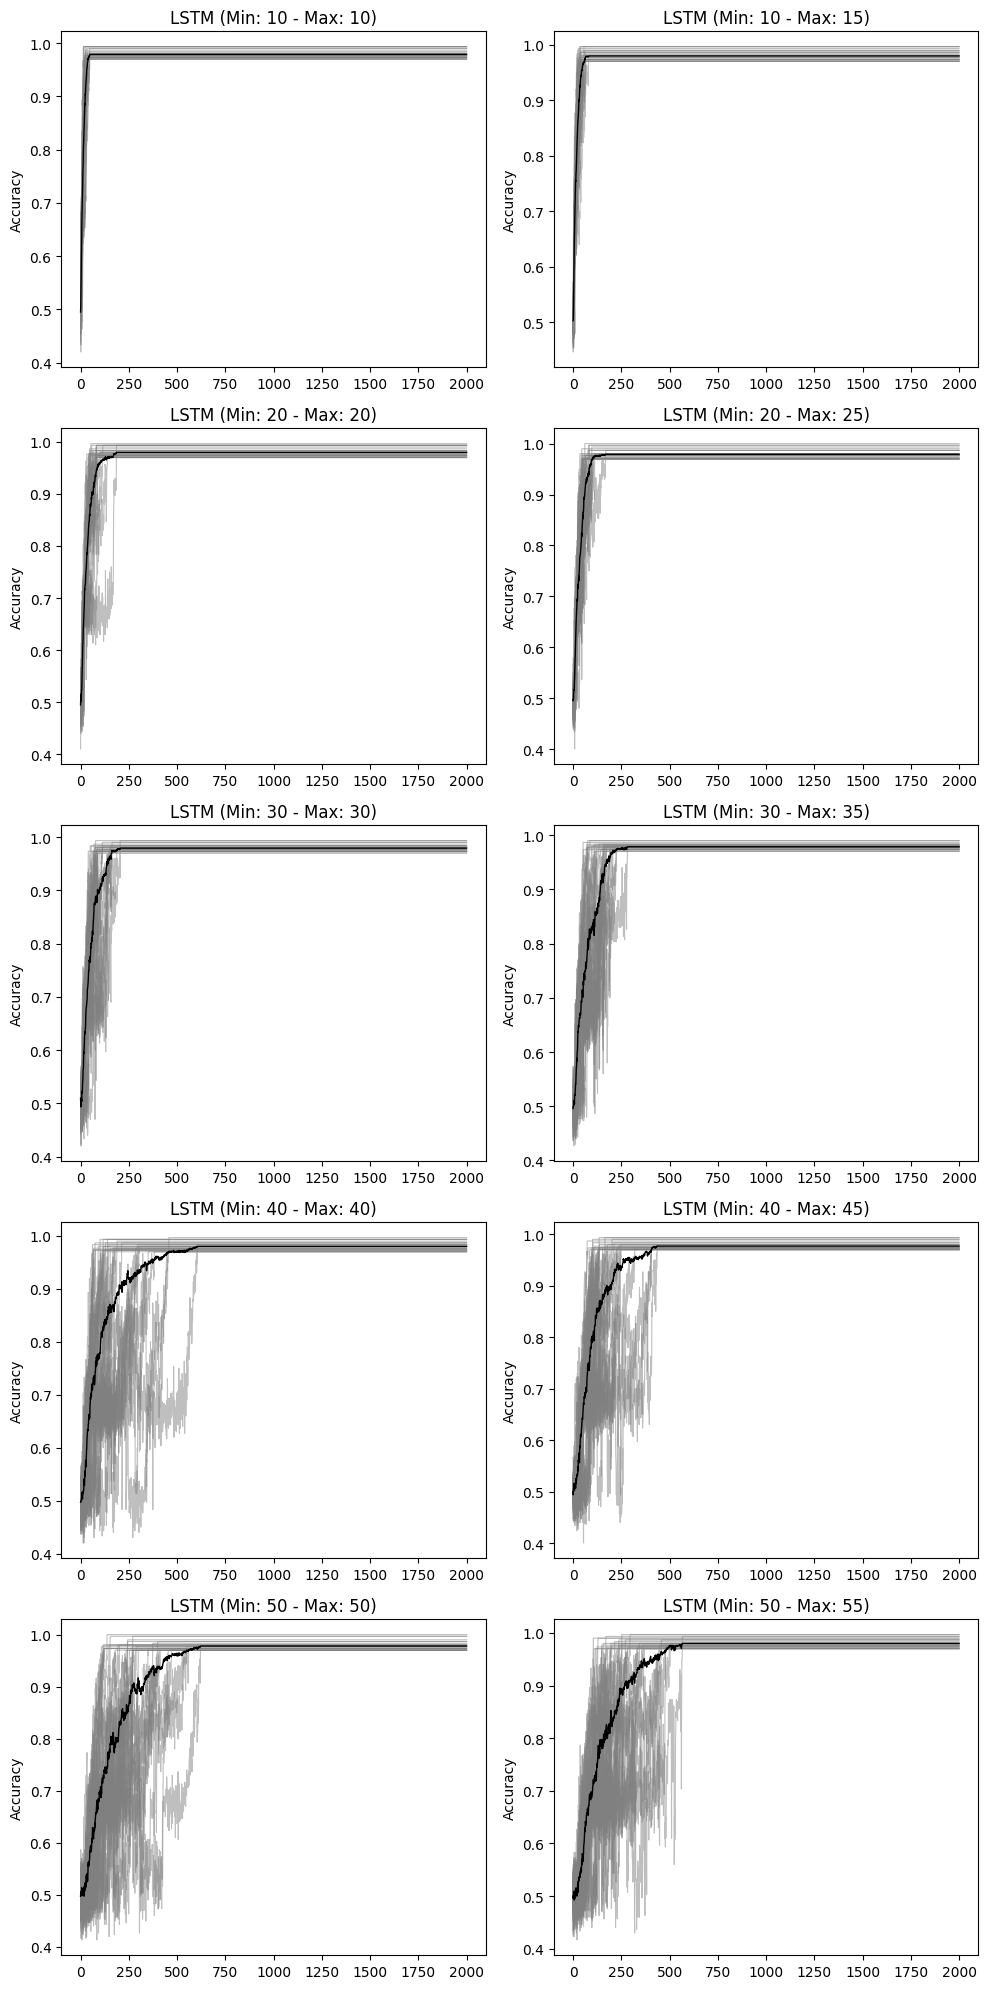

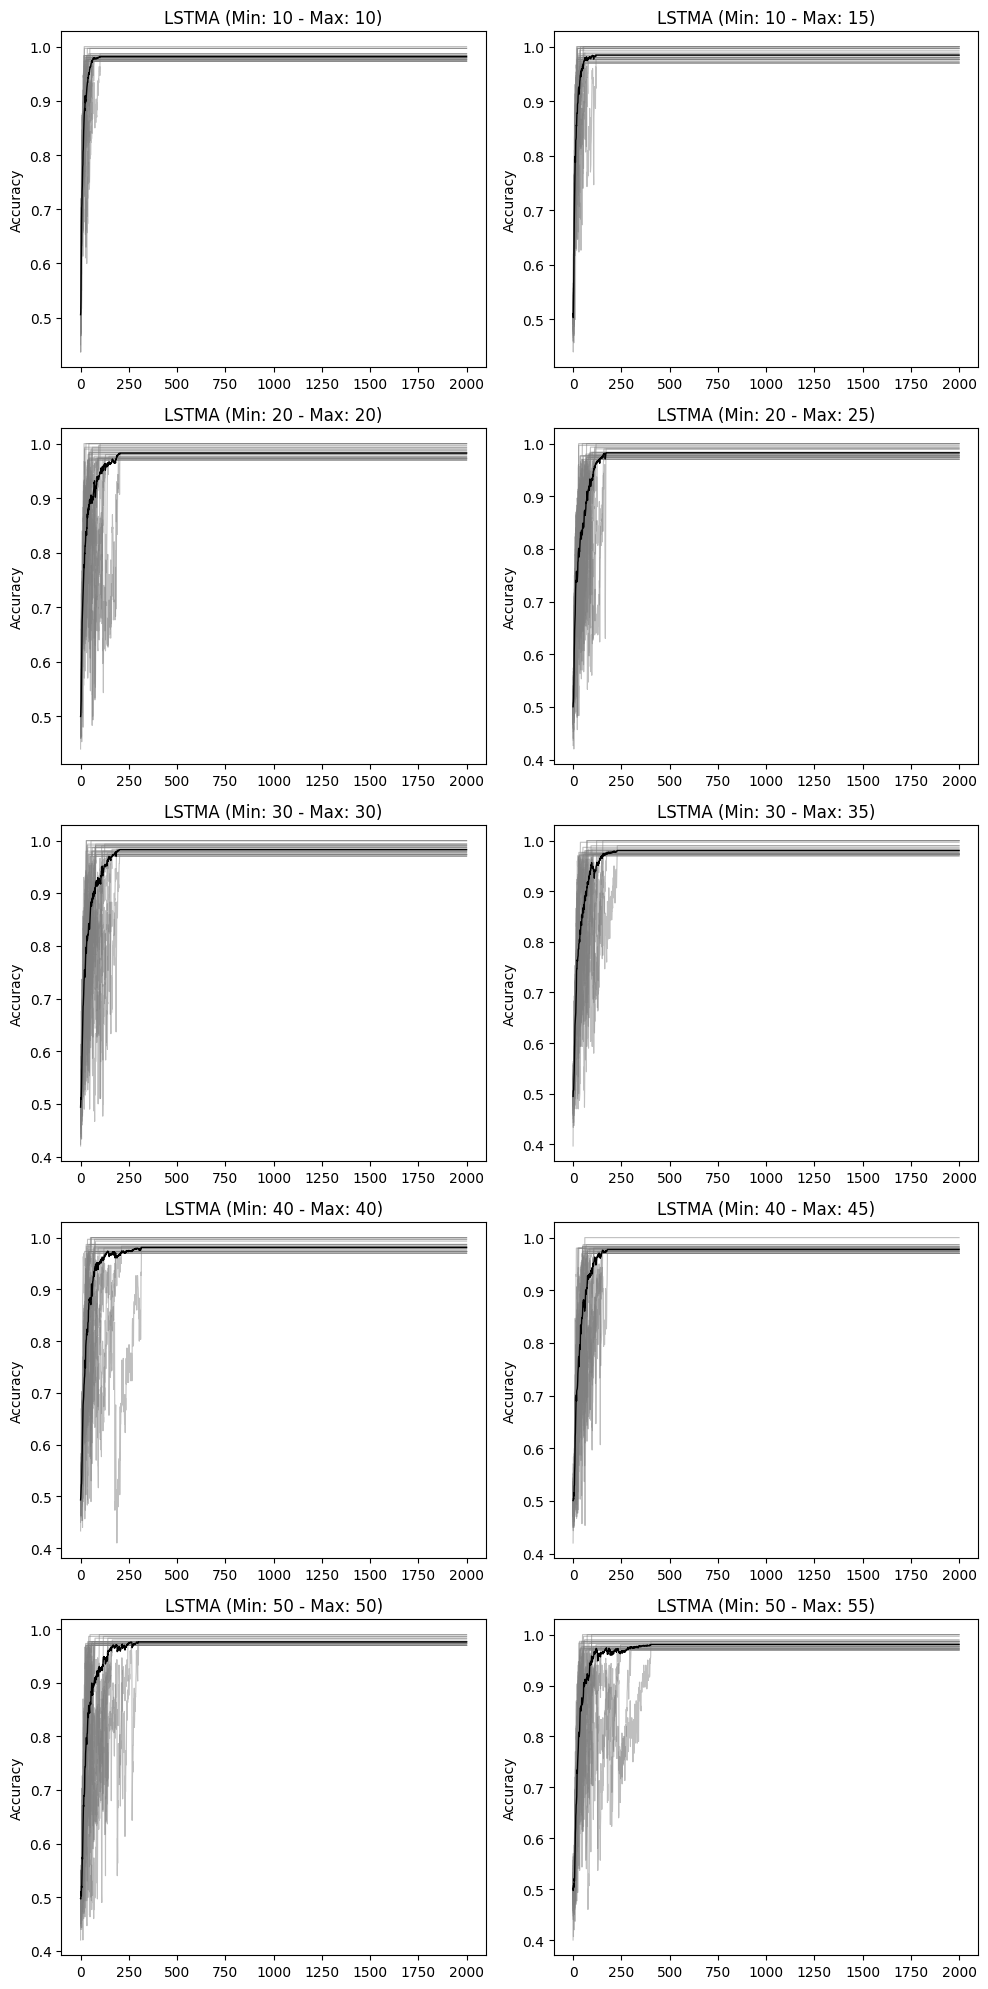

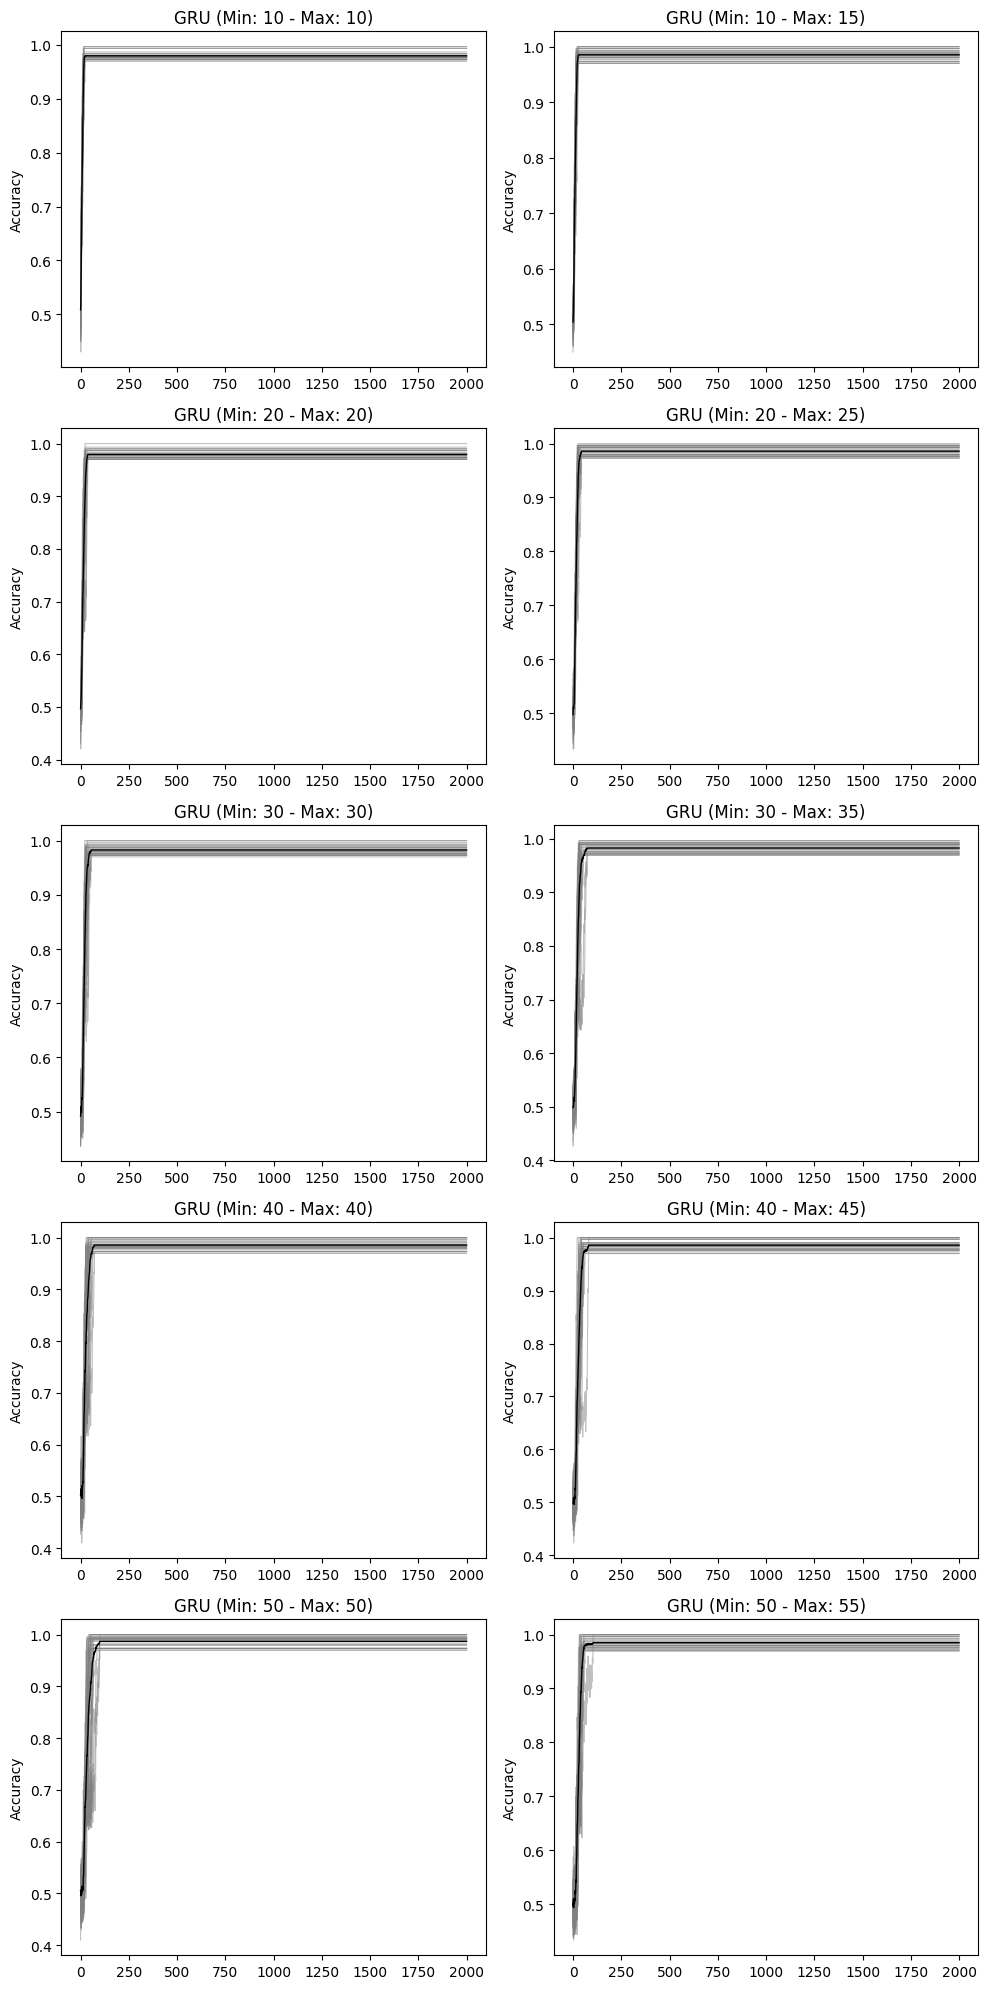

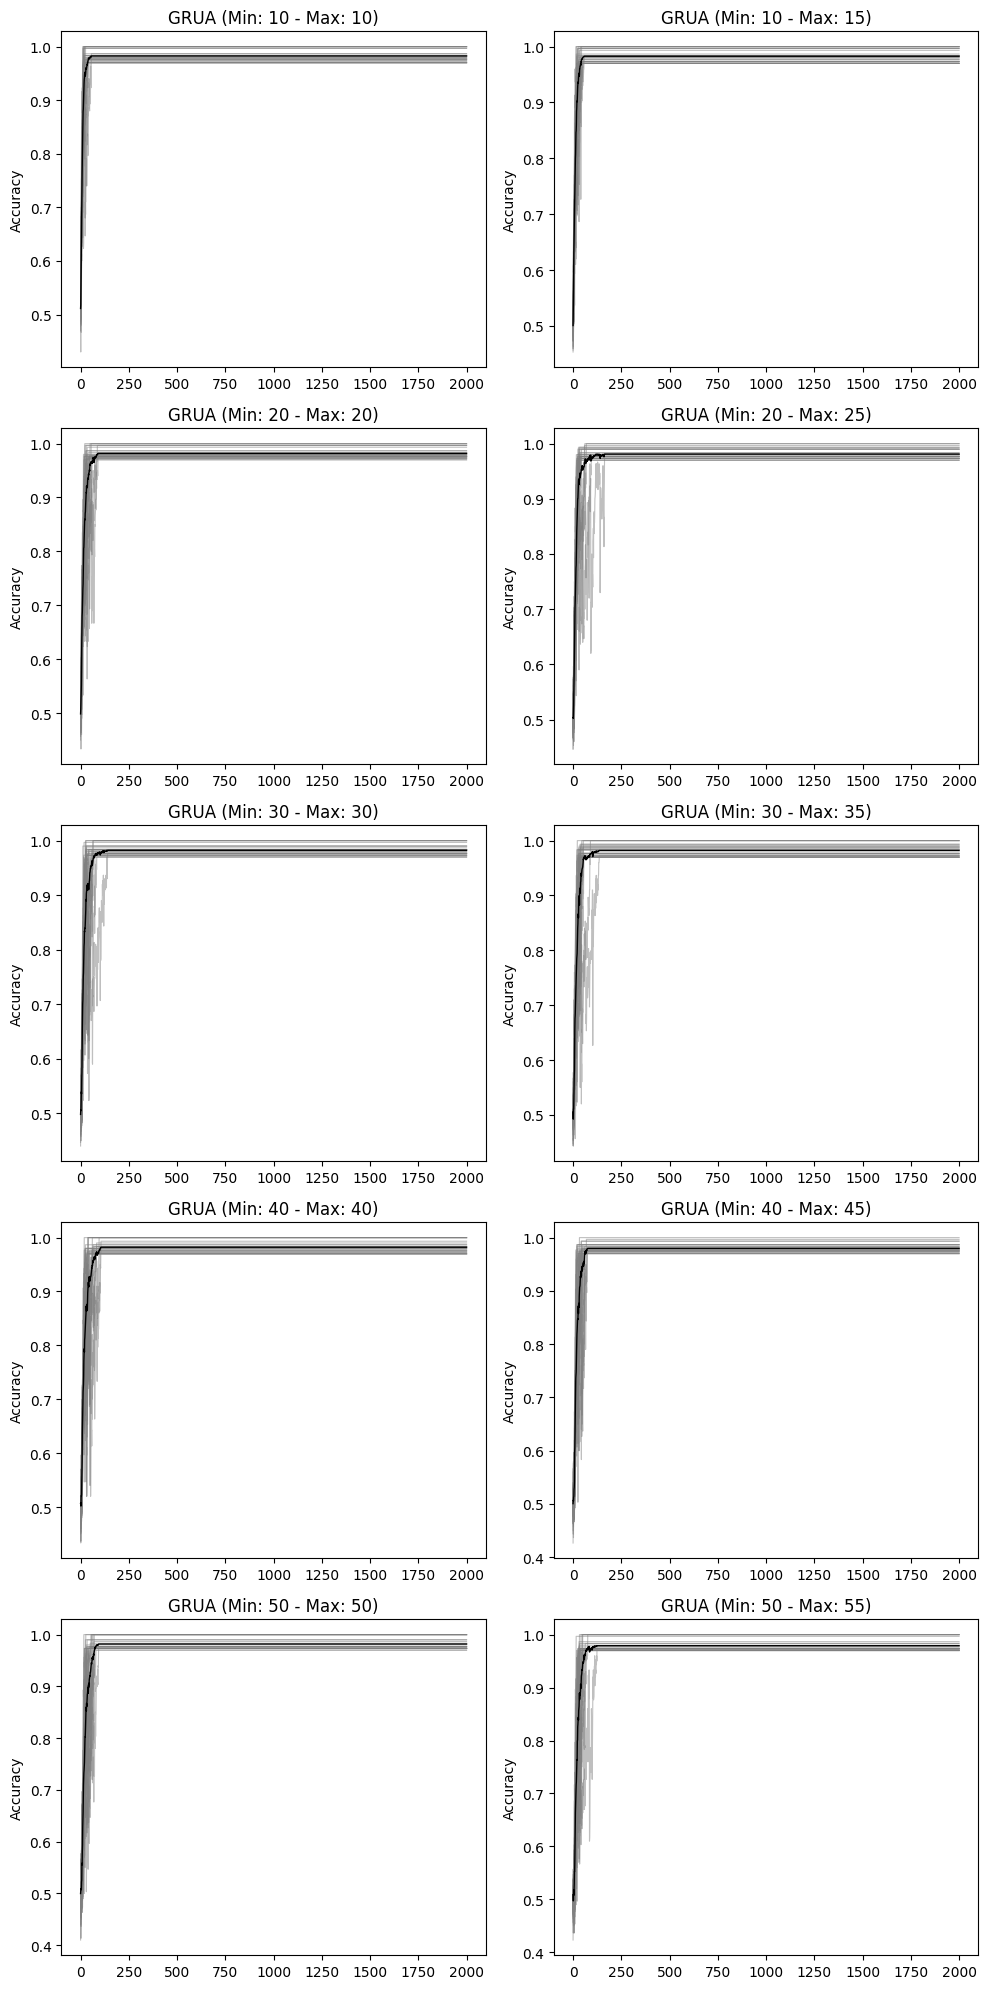

Skipped Models: ['RNN_min_50_max_50_rep_2', 'RNN_min_50_max_50_rep_25']


In [87]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

skipped_models = []

# Plotting for each kind
for kind in kinds:
    plt.figure(figsize=(10, 20))  # Adjust the figure size for 2x5 layout

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid
        rep_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    rep_data.append(padded_data)
                    ax.plot(padded_data, label=f"Rep {rep+1}", alpha=0.5, linewidth=0.8, color='gray')
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if not rep_data:
            continue

        avg_data = np.mean(np.array(rep_data), axis=0)
        ax.plot(avg_data, label="Average", linewidth=1, color='black')

        ax.set_title(f"{kind} (Min: {min_len} - Max: {max_len})")
        ax.set_ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

# Print the skipped models
print("Skipped Models:", skipped_models)

In [ ]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Adjusting the plot to grayscale and using fill_between for replicates
def plot_with_grayscale_fill_between(kind, min_lengths, max_lengths, num_reps, target_epoch):
    plt.figure(figsize=(10, 10))  # Adjust the figure size for layout

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

        rep_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    rep_data.append(padded_data)
            except FileNotFoundError:
                continue

        if not rep_data:
            continue

        avg_data = np.mean(rep_data, axis=0)
        std_dev = np.std(rep_data, axis=0)

        # Plot replicates as fill_between
        ax.fill_between(range(target_epoch), avg_data - std_dev, avg_data + std_dev, color='gray', alpha=0.3)
        
        # Plot average as a black line
        ax.plot(avg_data, label="Average", linewidth=2, color='black')

        ax.set_title(f"{kind} (Min: {min_len} - Max: {max_len})")
        ax.set_ylabel("Accuracy")
        ax.set_xlabel("Epoch")

    plt.tight_layout()
    plt.show()

# Plotting for each kind
for kind in kinds:
    plot_with_grayscale_fill_between(kind, min_lengths, max_lengths, num_reps, target_epoch)


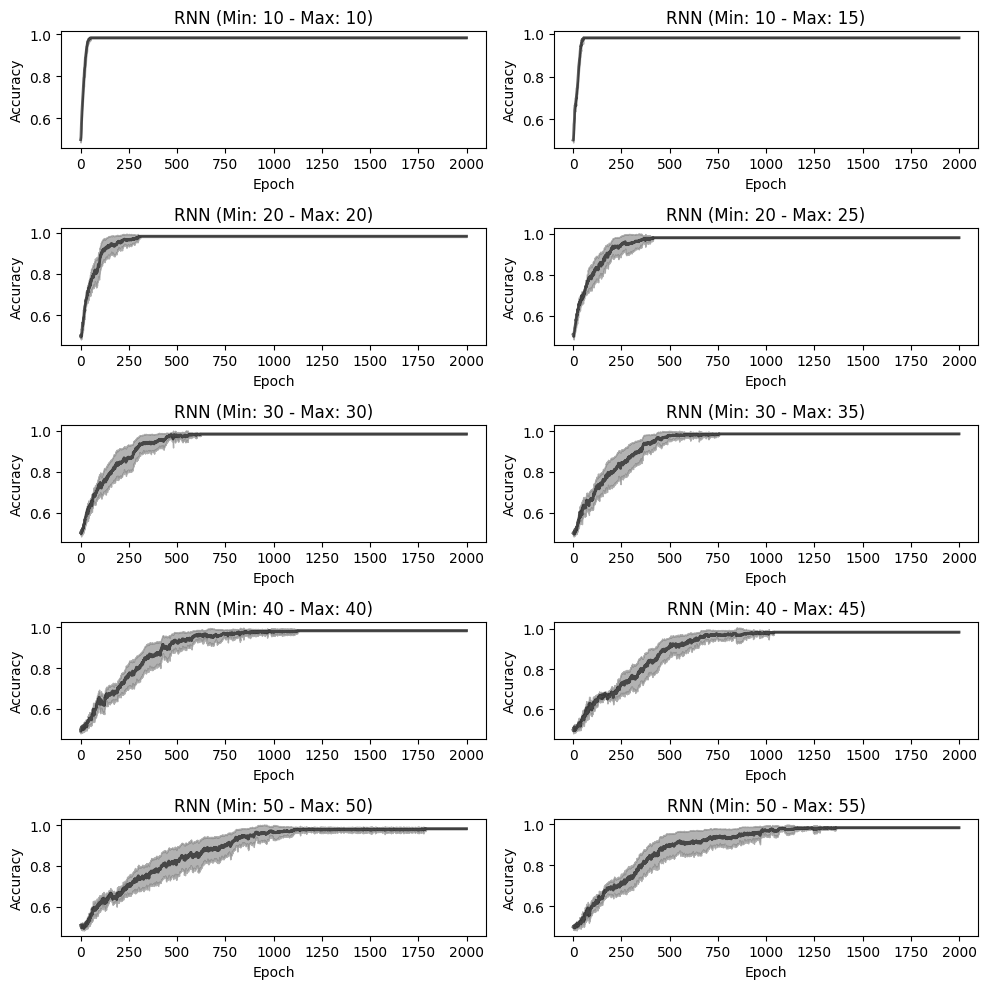

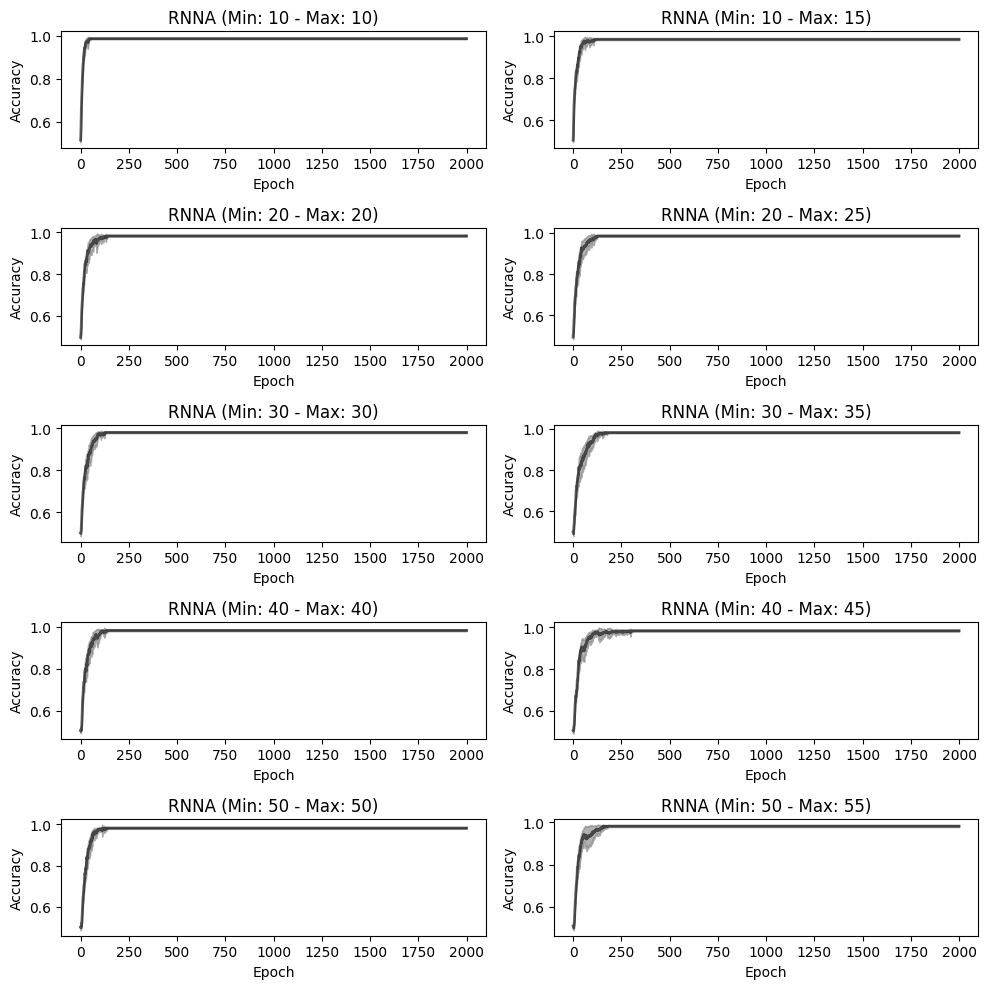

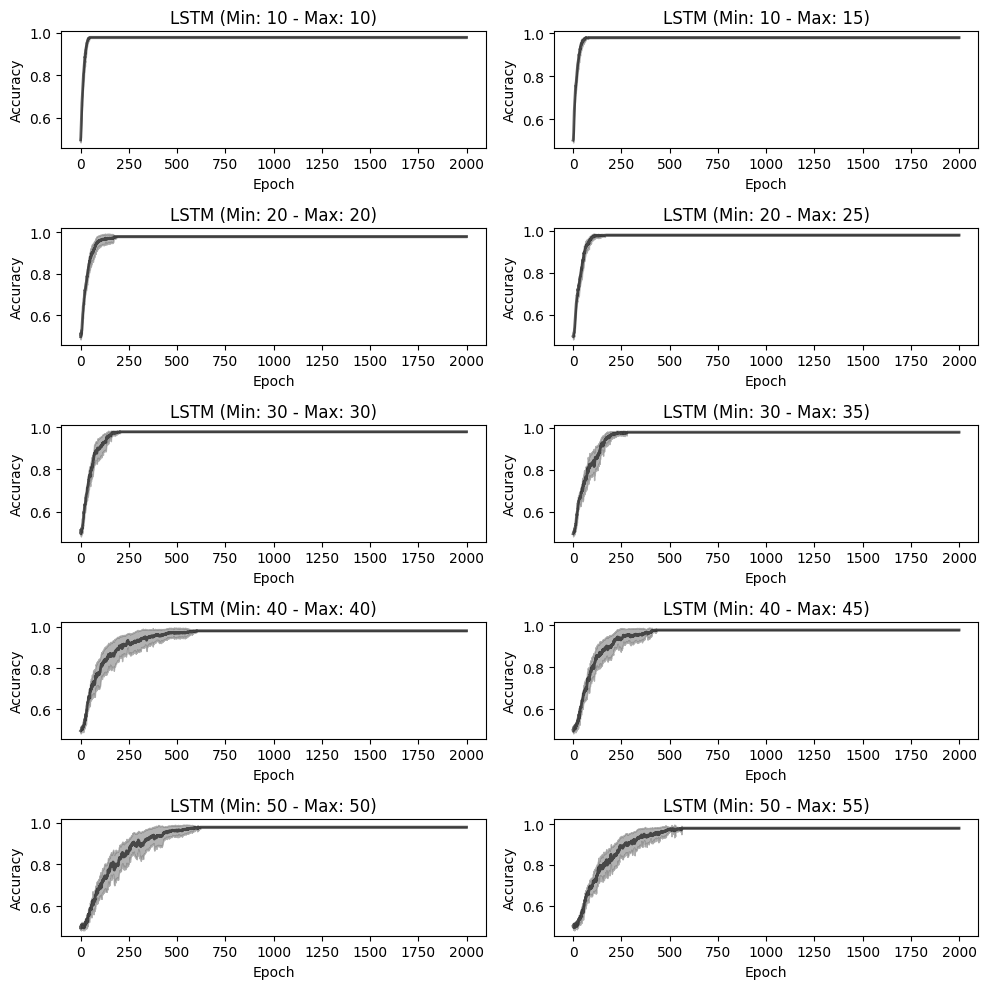

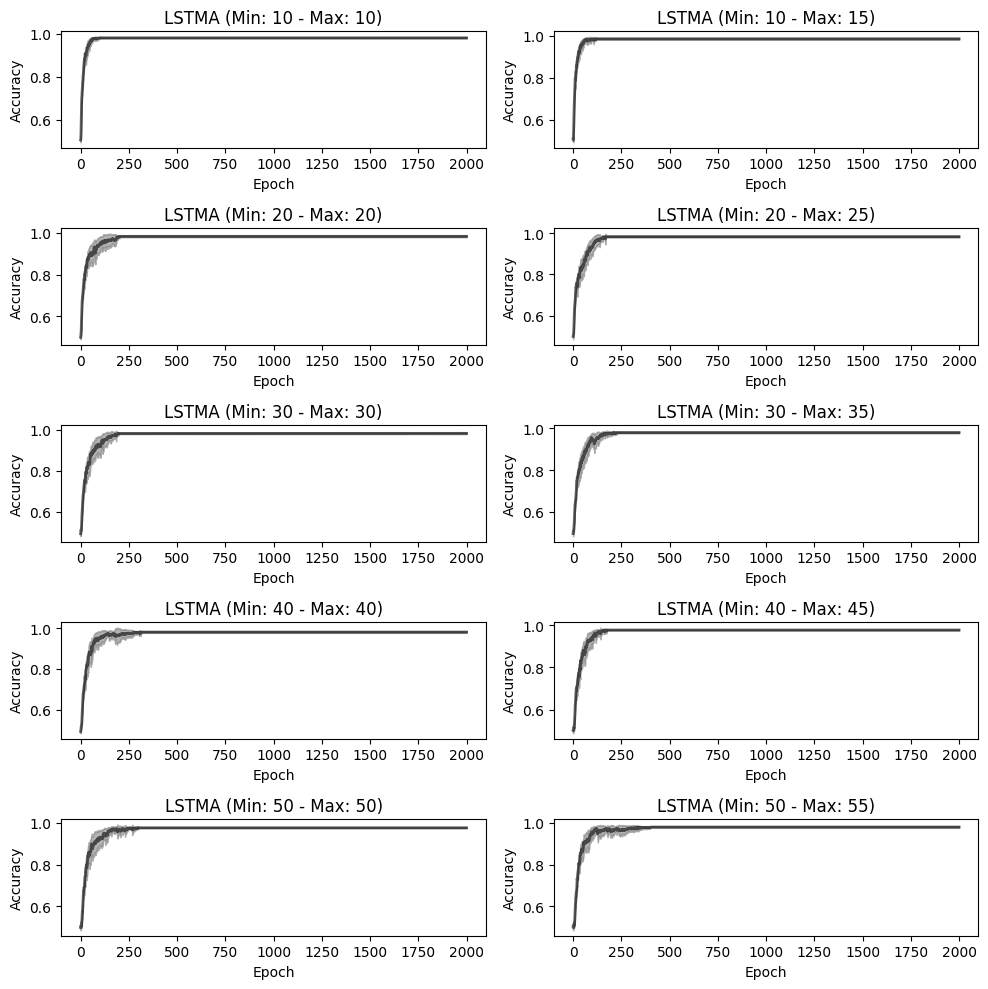

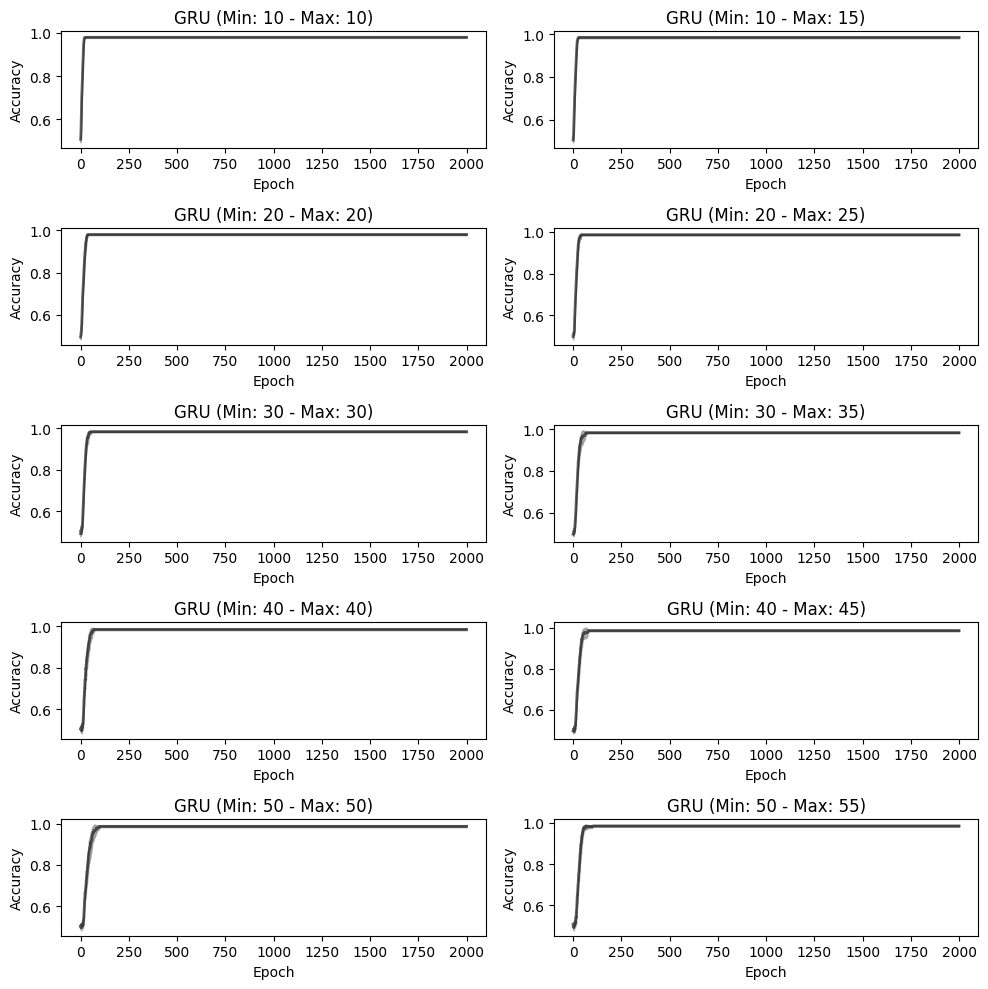

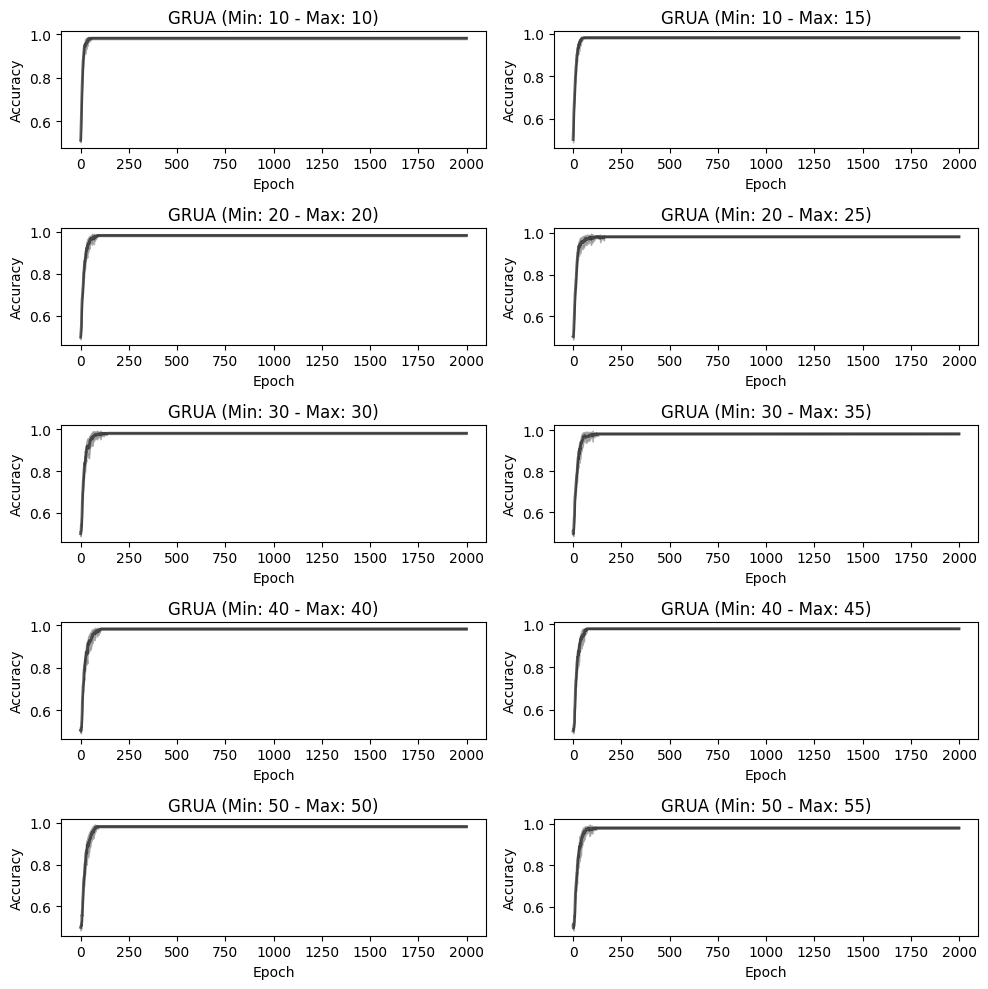

In [118]:
def mean_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    n = len(data)
    m = np.mean(data, axis=0)
    se = scipy.stats.sem(data, axis=0)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def plot_with_grayscale_fill_between(kind, min_lengths, max_lengths, num_reps, target_epoch):
    plt.figure(figsize=(10, 10))  # Adjust the figure size for layout

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

        rep_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    rep_data.append(padded_data)
            except FileNotFoundError:
                continue

        if not rep_data:
            continue

        # Calculate the mean and confidence intervals for each epoch
        avg_data, lower_bound, upper_bound = mean_confidence_interval(rep_data, confidence=0.97)

        # Plot confidence interval as fill_between
        ax.fill_between(range(target_epoch), lower_bound, upper_bound, color='gray', alpha=0.6)

        # Plot average as a black line
        ax.plot(avg_data, label="Average", linewidth=2, color='black', alpha=0.6)

        ax.set_title(f"{kind} (Min: {min_len} - Max: {max_len})")
        ax.set_ylabel("Accuracy")
        ax.set_xlabel("Epoch")

    plt.tight_layout()
    plt.show()

# Plotting for each kind
for kind in kinds:
    plot_with_grayscale_fill_between(kind, min_lengths, max_lengths, num_reps, target_epoch)


In [ ]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50, 10, 20, 30, 40, 50]
max_lengths = [10, 20, 30, 40, 50, 15, 25, 35, 45, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the plots
plt.figure(figsize=(15, 15))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # Create subplots in a 3x2 grid

    for j, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        combination_avg_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    combination_avg_data.append(padded_data)
            except FileNotFoundError:
                continue

        if combination_avg_data:
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            line_style = '--' if min_len == max_len else '-'
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}", linewidth=0.8, linestyle=line_style)

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    if i == 0:  # Add legend only to the first subplot
        ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50]  # Adjusted values
max_lengths = [15, 25, 35, 45, 55]  # Adjusted values
num_reps = 31  # Number of repetitions
target_epoch = 2000  # Target number of epochs
skipped_models = []

# Create a single figure for the 3x3 grid
plt.figure(figsize=(15, 15))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3,2, i + 1)  # Create subplots in a 3x3 grid

    for min_len, max_len in zip(min_lengths, max_lengths):
        combination_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    combination_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if combination_avg_data:
            # Calculate the average for this min/max length combination
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}")

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()




C:\Users\ahmad\AppData\Local\Temp\ipykernel_8700\2324519471.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blue_cmap = plt.cm.get_cmap('Blues')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_8700\2324519471.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red_cmap = plt.cm.get_cmap('Reds')


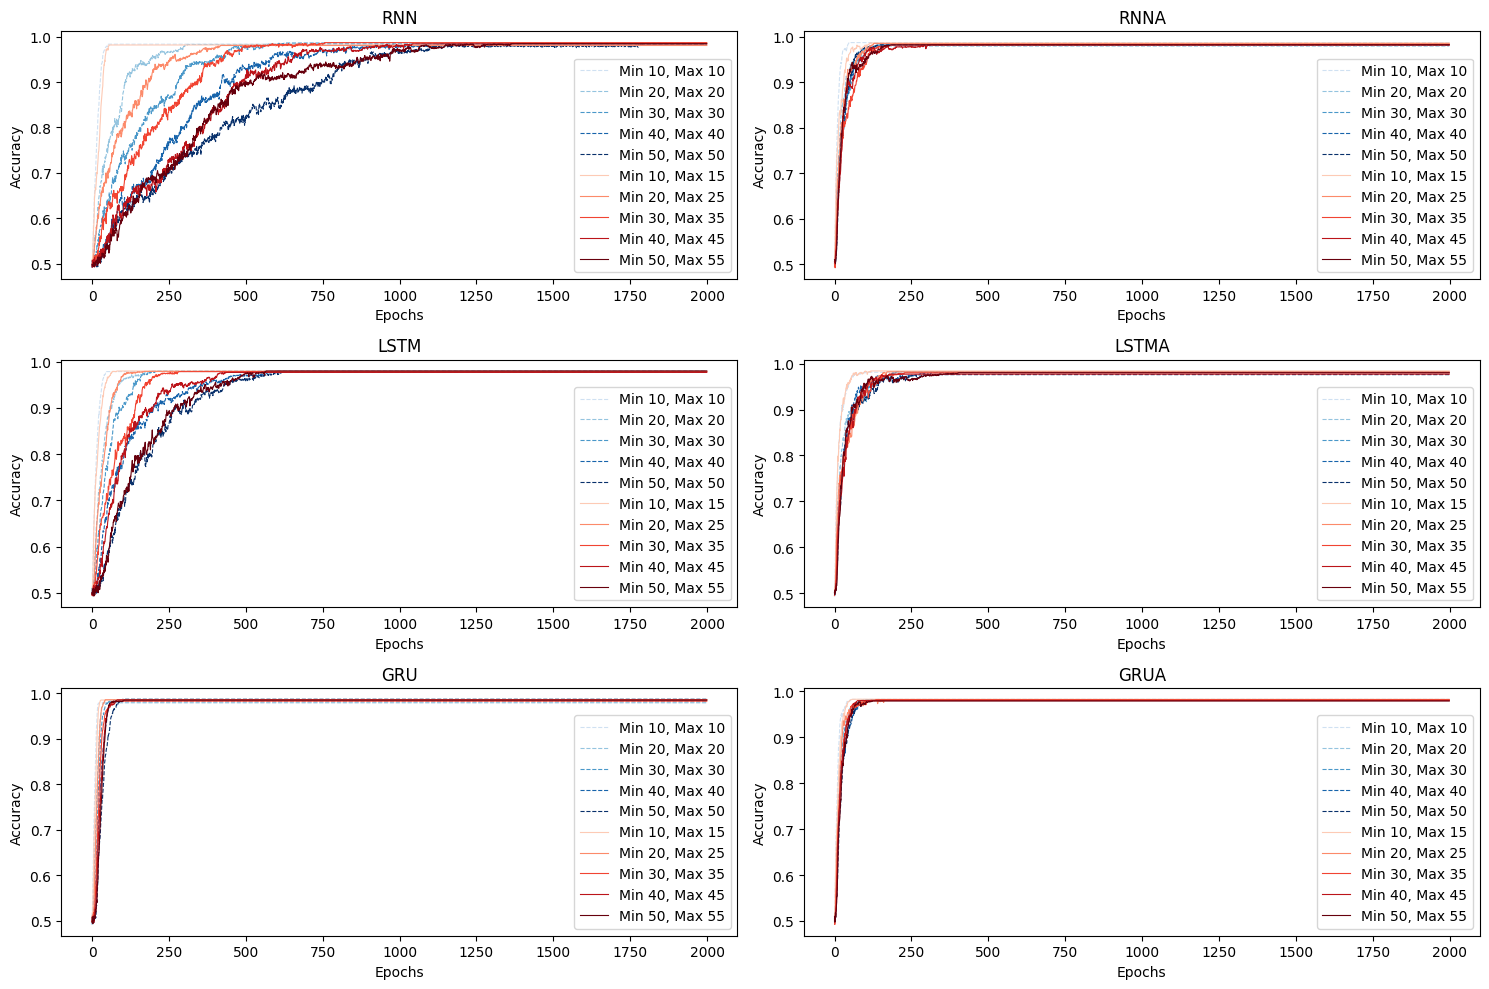

In [122]:
# Kinds, lengths, repetitions, and other parameters as provided
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50, 10, 20, 30, 40, 50]
max_lengths = [10, 20, 30, 40, 50, 15, 25, 35, 45, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the 3x3 grid (adjusted to 3x2 as per the kinds list)
plt.figure(figsize=(15, 10))

# Define color maps for blue and red spectrums
blue_cmap = plt.cm.get_cmap('Blues')
red_cmap = plt.cm.get_cmap('Reds')

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # Create subplots in a 3x2 grid

    for min_len, max_len in zip(min_lengths, max_lengths):
        combination_avg_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    combination_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if combination_avg_data:
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            if min_len == max_len:
                # Dashed line - Spectrum of blue
                color = blue_cmap(min_len / 50)  # Normalize to get a color from the blue spectrum
                line_style = '--'
            else:
                # Solid line - Spectrum of red
                color = red_cmap(min_len / 50)  # Normalize to get a color from the red spectrum
                line_style = '-'
            
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}", linewidth=0.8, linestyle=line_style, color=color)

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
kinds = ["RNN", "LSTM","GRU"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


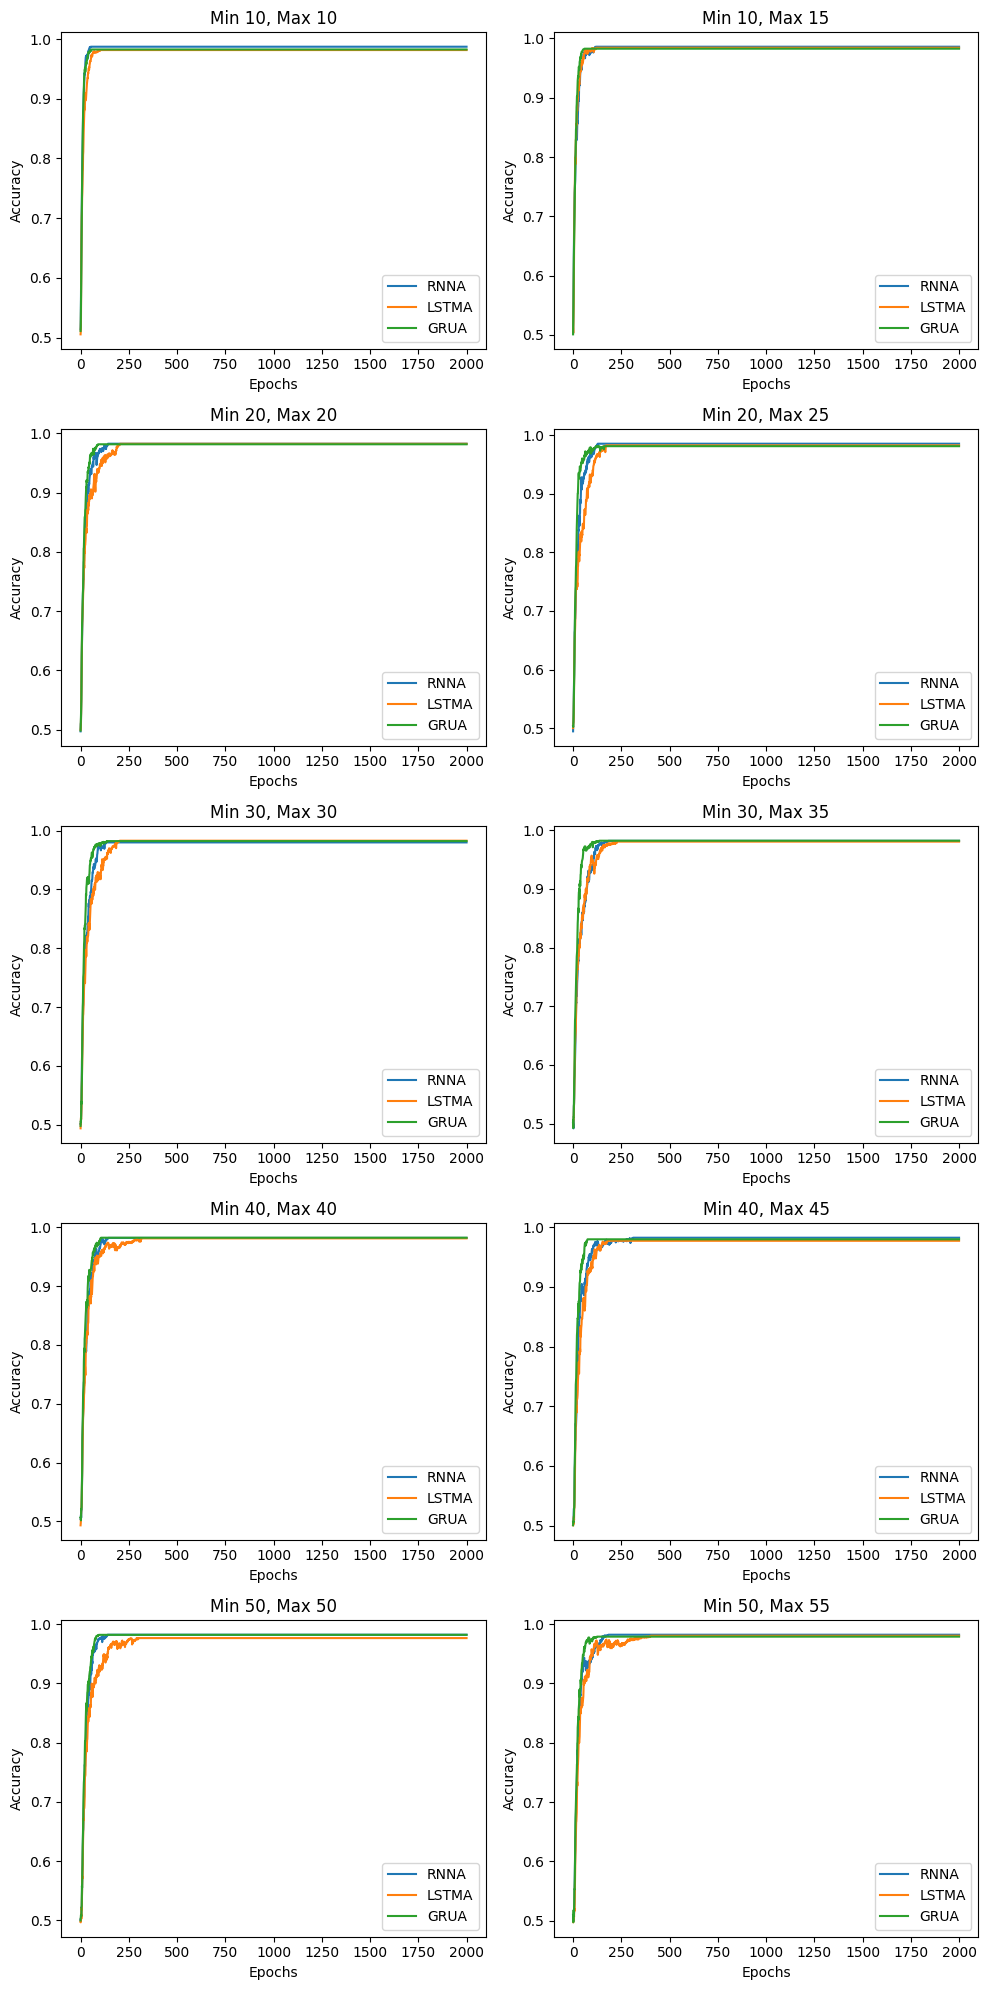

In [123]:
kinds = ["RNNA", "LSTMA",  "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
kinds = ["RNNE", "LSTME", "GRUE"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


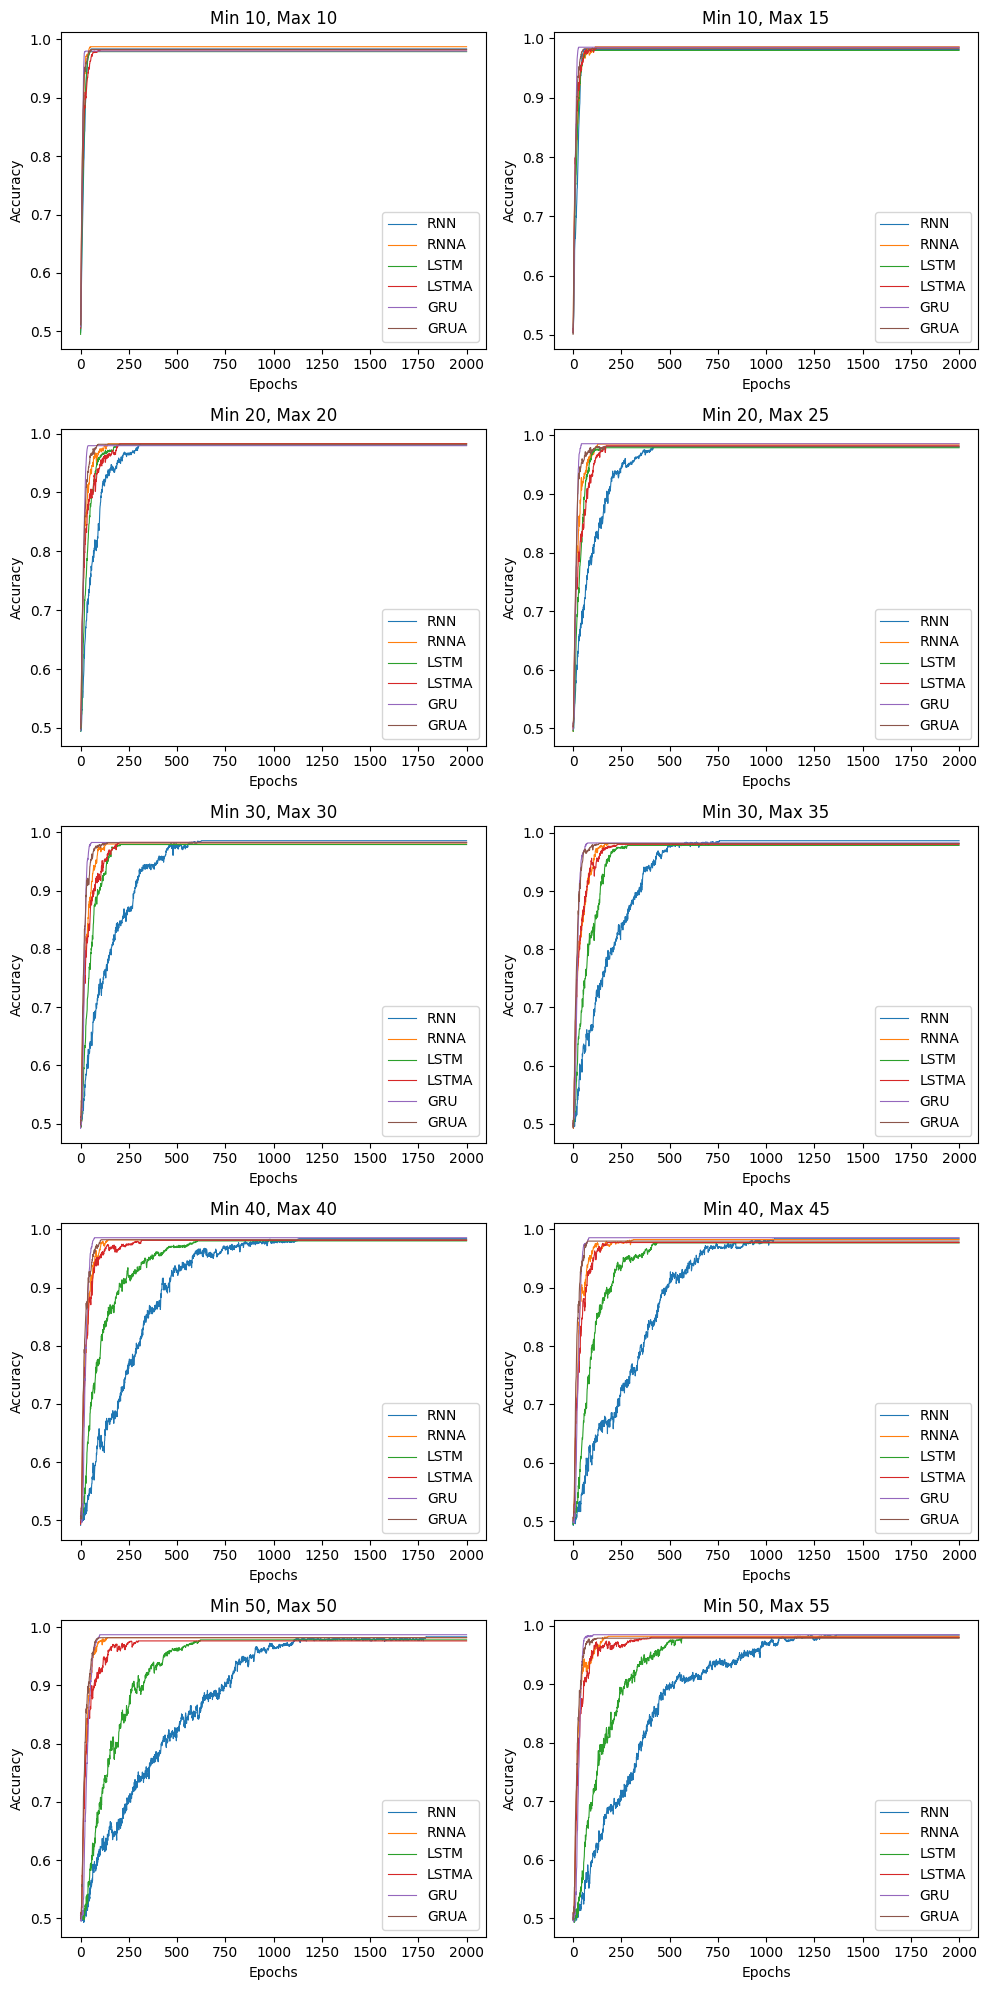

In [124]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}", linewidth= 0.8)

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
#model_groups = {
#    "RNN": ["RNN", "RNNA", "RNNE"],
#    "LSTM": ["LSTM", "LSTMA", "LSTME"],
#    "GRU": ["GRU", "GRUA", "GRUE"]
#}

model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Plotting for each model group
for group_name, kinds in model_groups.items():
    plt.figure(figsize=(10, 20))  # Create a single figure for the 2x5 grid

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

        for kind in kinds:
            kind_avg_data = []

            for rep in range(num_reps):
                #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                    if should_skip:
                        skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                        continue
                    if padded_data is not None:
                        kind_avg_data.append(padded_data)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if kind_avg_data:
                # Calculate the average for this kind and length combination
                avg_data = np.mean(np.array(kind_avg_data), axis=0)
                ax.plot(avg_data, label=f"{kind}")

        ax.set_title(f"Min {min_len}, Max {max_len}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Accuracy")
        ax.legend()

    plt.suptitle(f"Average Accuracy for {group_name} Models")
    plt.tight_layout()
    plt.show()


# Bar plots

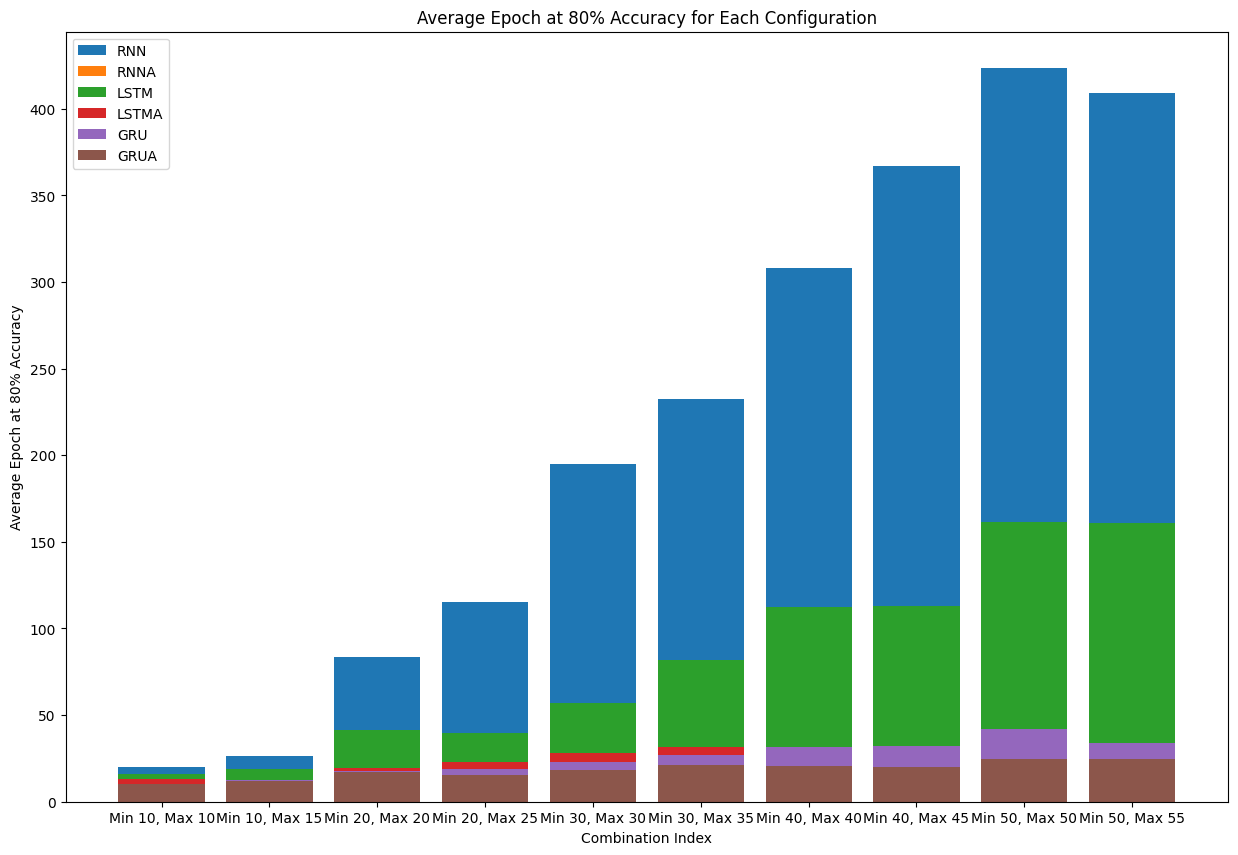

In [75]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]

# Placeholder for the results
results = []
labels = []

for kind in kinds:
    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results.append((kind, min_len, max_len, avg_epoch))
            labels.append(f"Min {min_len}, Max {max_len}")


# Preparing data for bar plot
df = pd.DataFrame(results, columns=["Kind", "Min_Length", "Max_Length", "Avg_Epoch"])

# Plotting
plt.figure(figsize=(15, 10))

for i, kind in enumerate(kinds):
    subset = df[df['Kind'] == kind]
    x = range(len(subset))
    plt.bar(x, subset['Avg_Epoch'], tick_label=labels[len(x)*i:len(x)*(i+1)],label=f"{kind}")

plt.xlabel("Combination Index")
plt.ylabel("Average Epoch at 80% Accuracy")
plt.title("Average Epoch at 80% Accuracy for Each Configuration")
plt.legend()
plt.show()

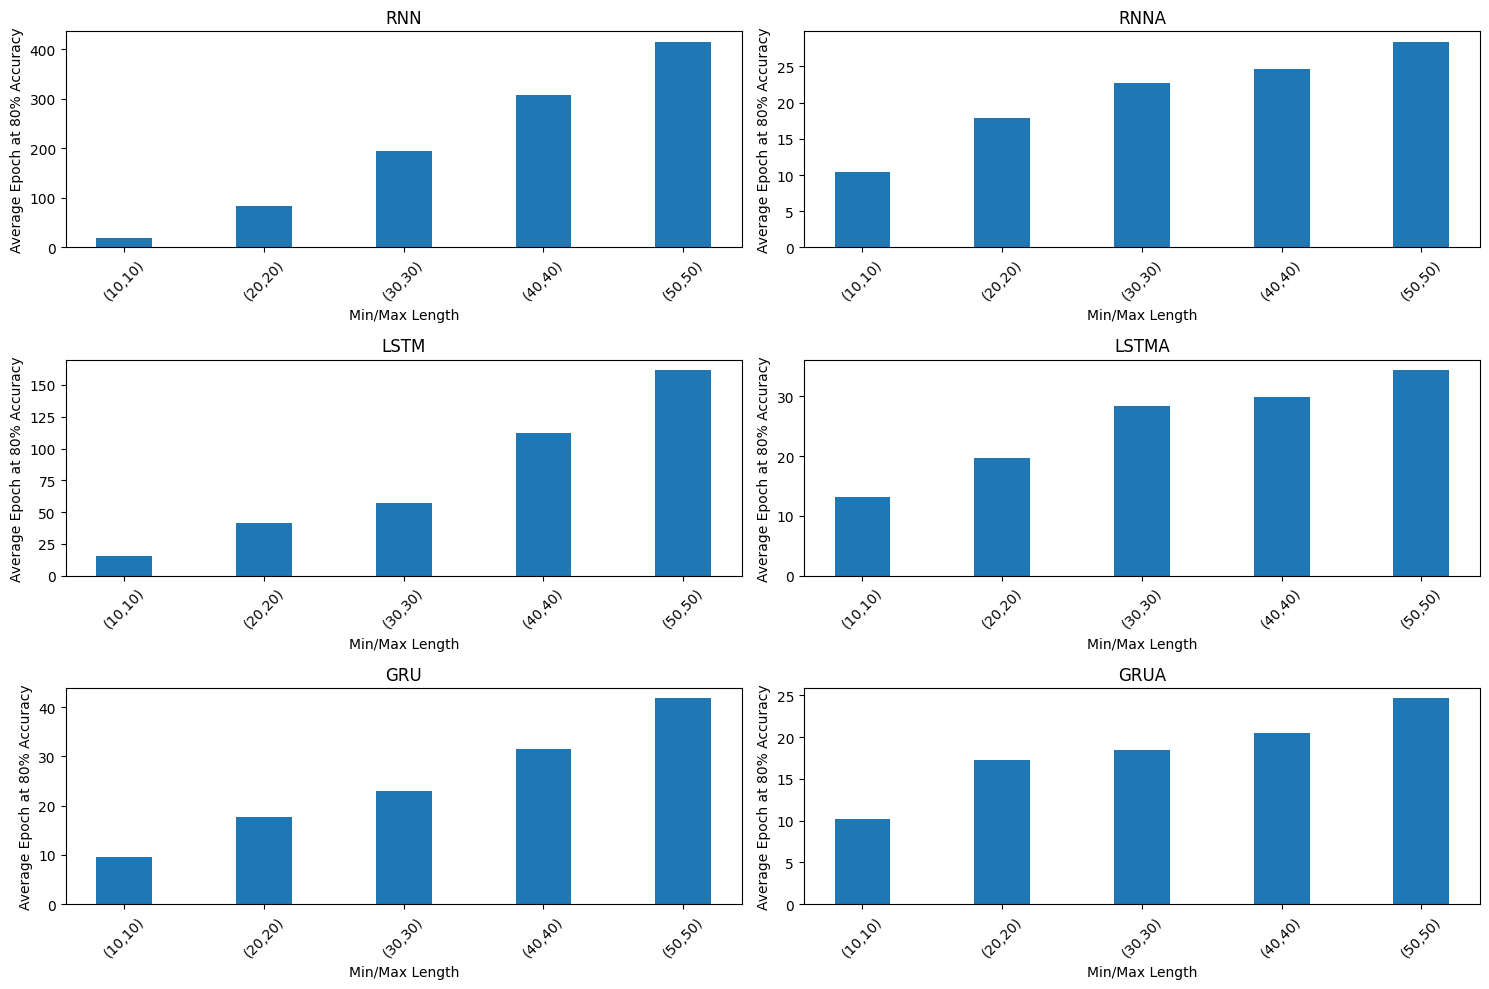

In [73]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [10 ,20, 30, 40, 50]
num_reps = 31
skipped_models = []

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model kind
for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # 3x2 grid for 6 kinds
    bar_positions = np.arange(len(min_lengths))  # One bar for each min/max length combination

    # Plot the bars
    ax.bar(bar_positions, results[i], width=0.4)

    # Set up the plot
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

plt.tight_layout()
plt.show()

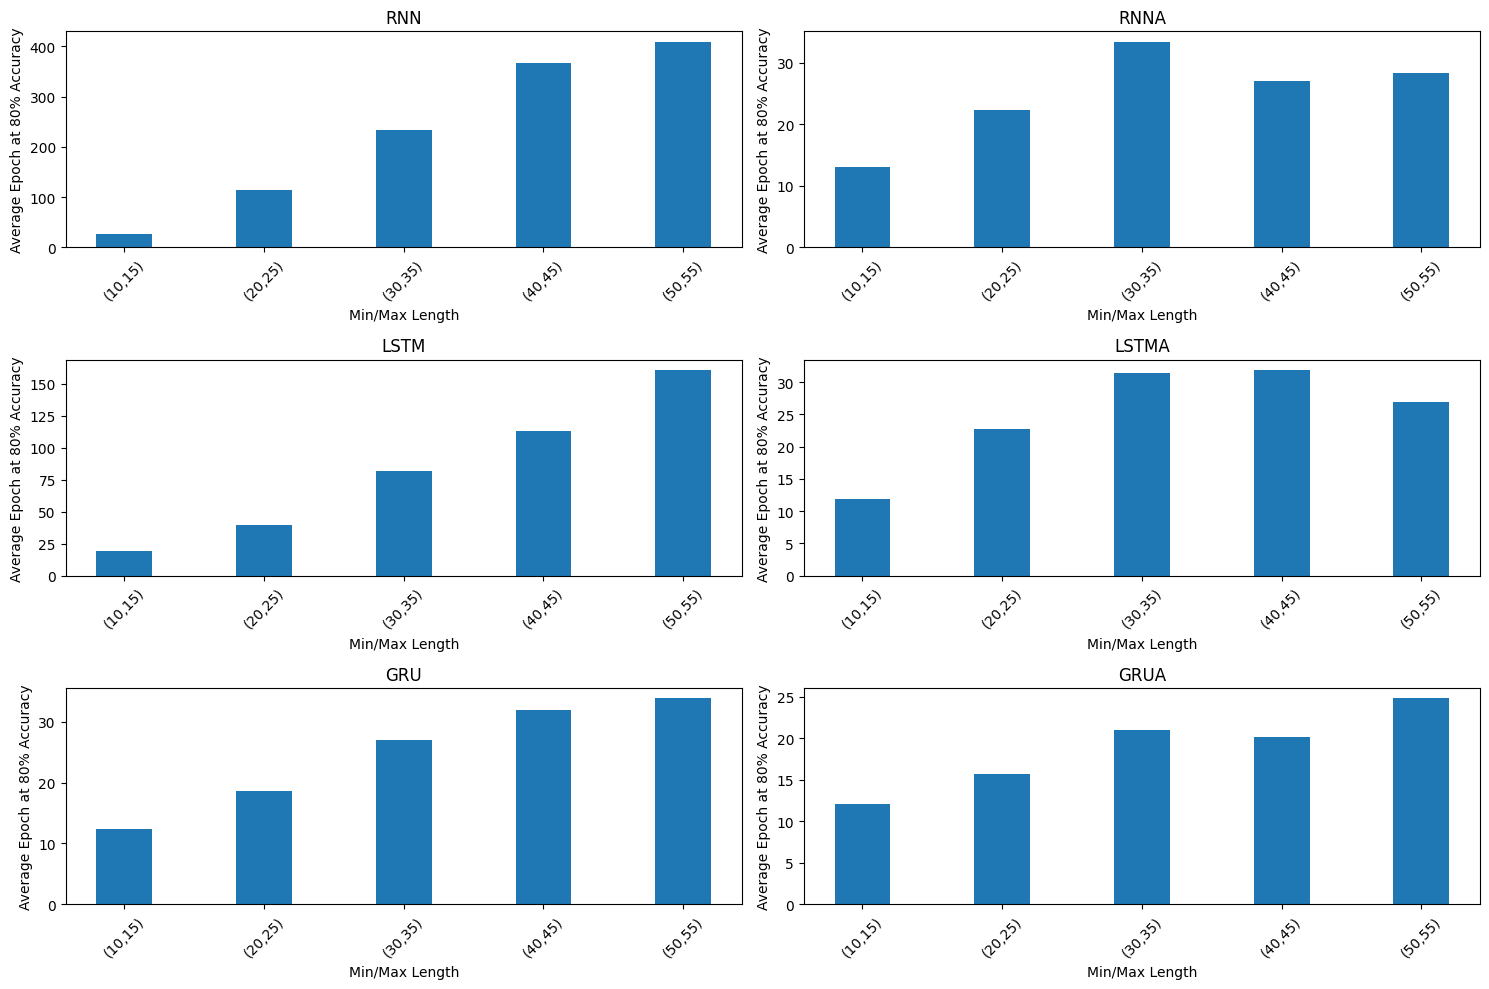

In [76]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [15 ,25, 35, 45, 55]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model kind
for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # 3x2 grid for 6 kinds
    bar_positions = np.arange(len(min_lengths))  # One bar for each min/max length combination

    # Plot the bars
    ax.bar(bar_positions, results[i], width=0.4)

    # Set up the plot
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

plt.tight_layout()
plt.show()

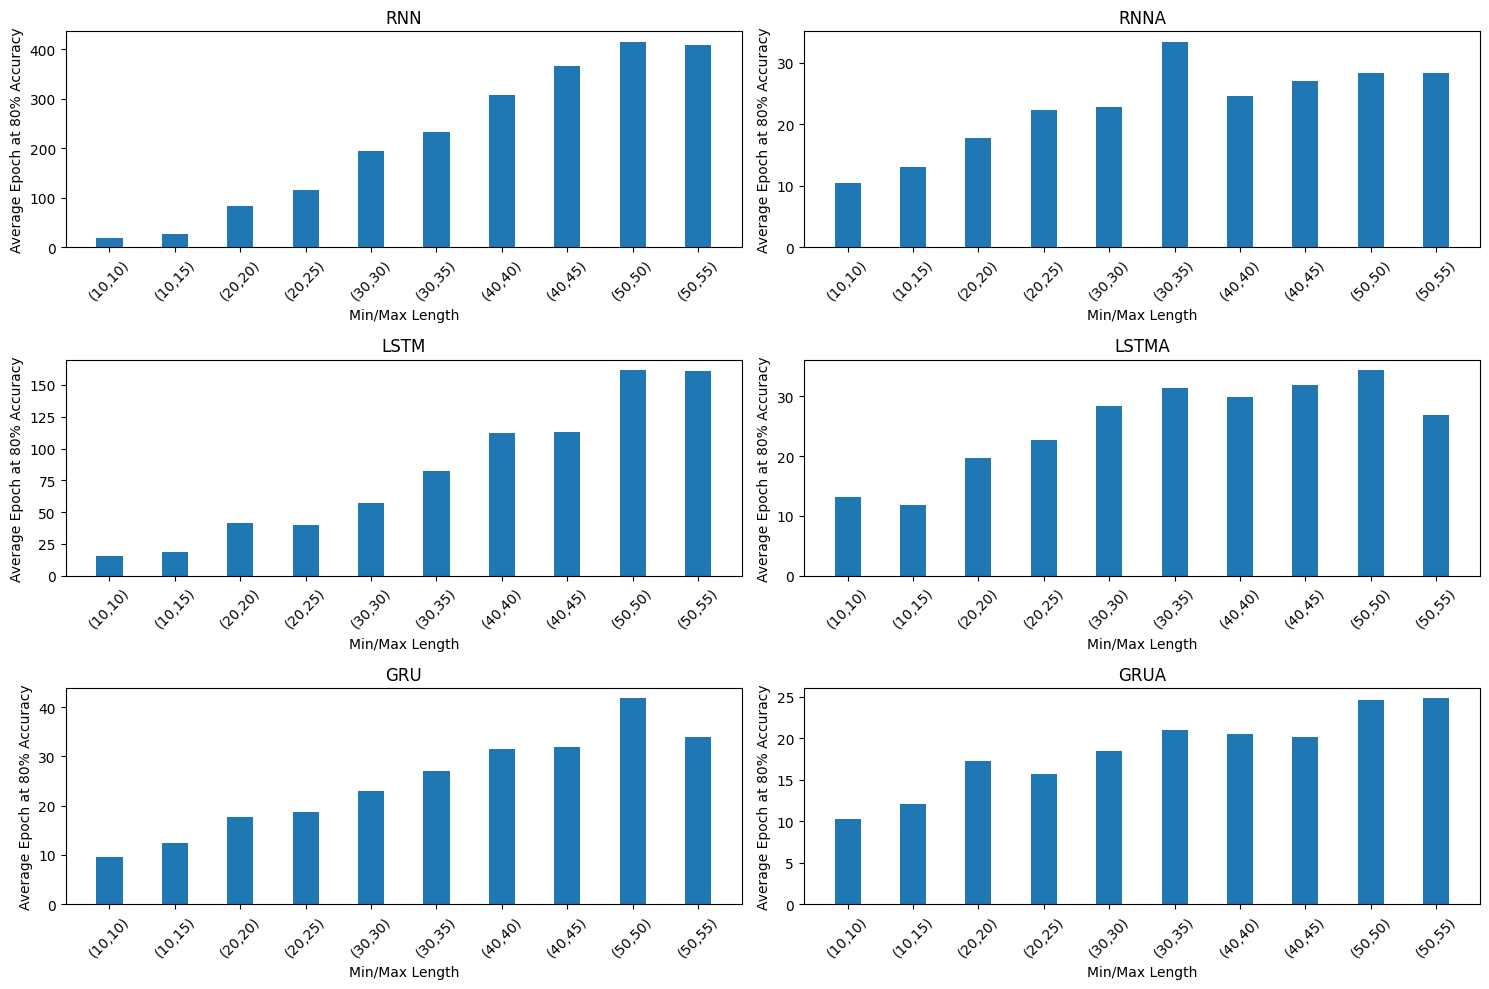

In [77]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model kind
for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # 3x2 grid for 6 kinds
    bar_positions = np.arange(len(min_lengths))  # One bar for each min/max length combination

    # Plot the bars
    ax.bar(bar_positions, results[i], width=0.4)

    # Set up the plot
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

plt.tight_layout()
plt.show()

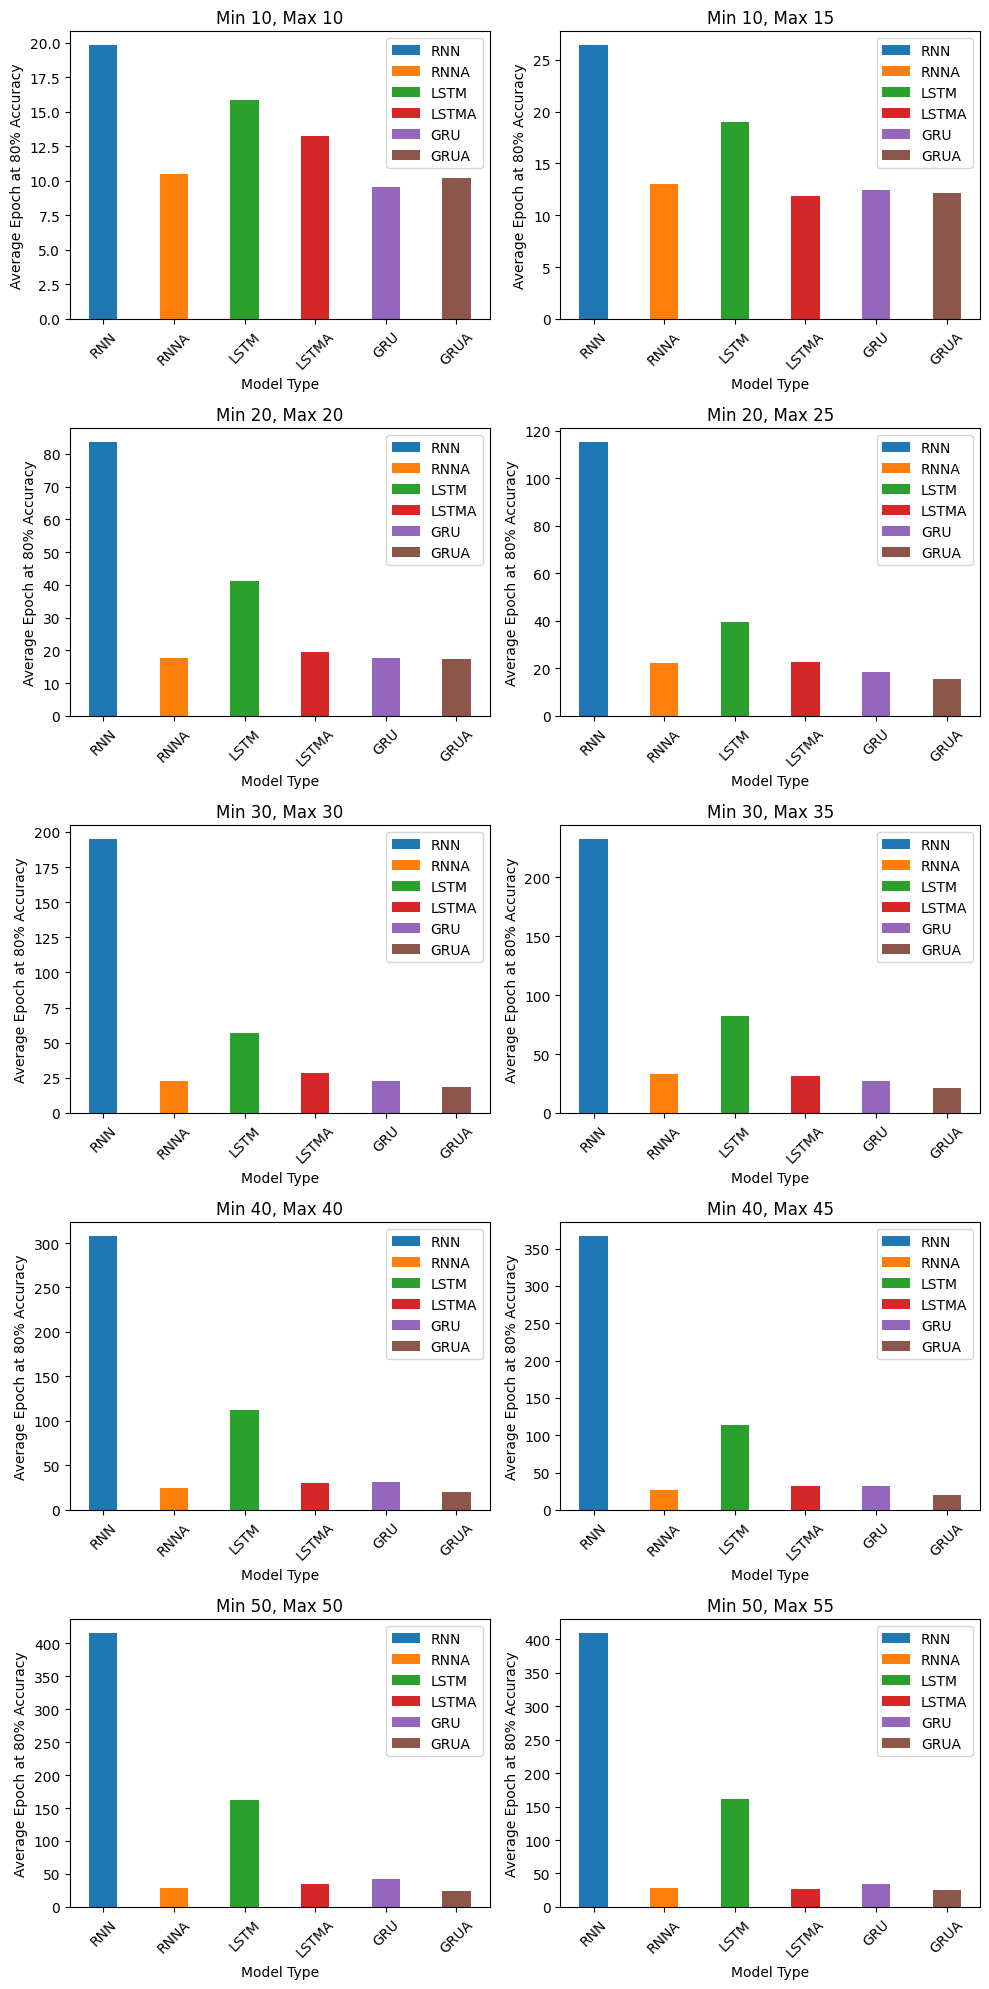

In [78]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Creating the bar plot
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed

# Create a subplot for each min/max length configuration
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # 5x2 grid for 10 configurations
    bar_positions = np.arange(len(kinds))  # One bar for each model kind

    # Plot the bars
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)

    # Set up the plot
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


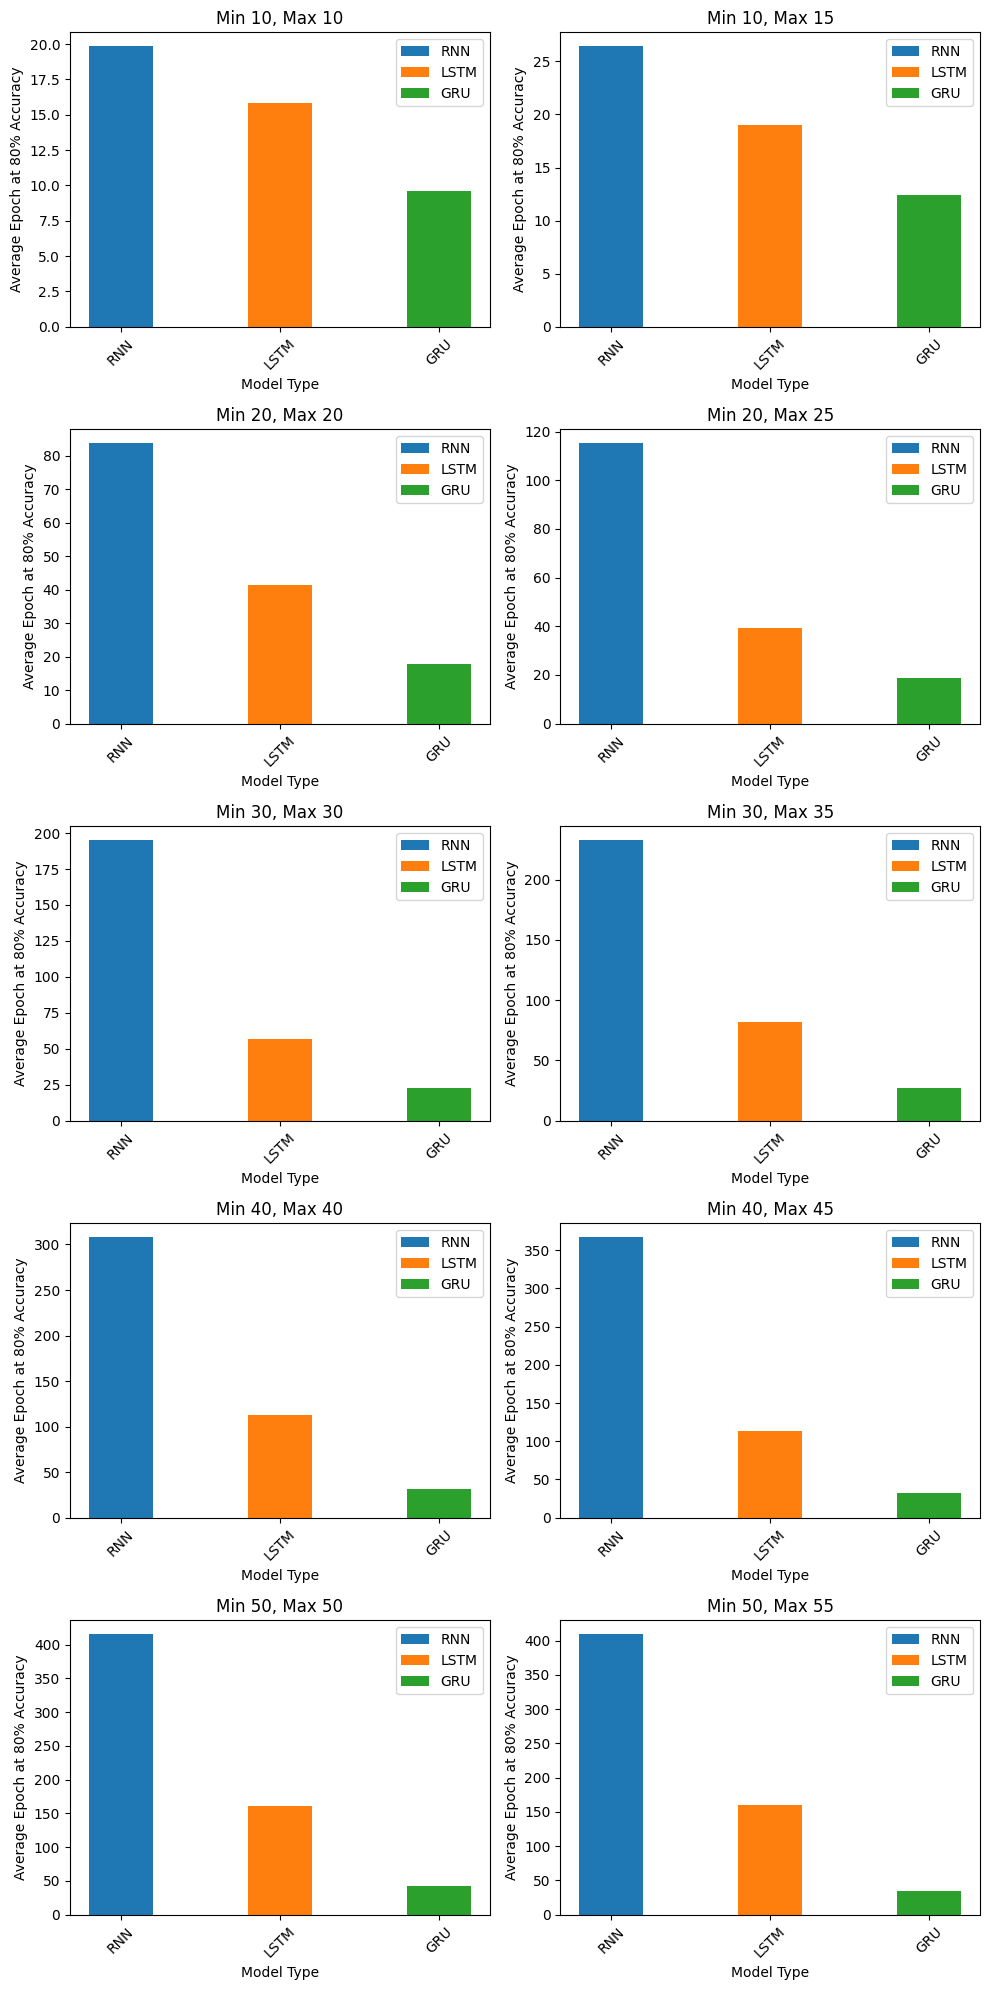

In [80]:
# Constants
kinds = ["RNN", "LSTM", "GRU", ]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Creating the bar plot
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed

# Create a subplot for each min/max length configuration
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # 5x2 grid for 10 configurations
    bar_positions = np.arange(len(kinds))  # One bar for each model kind

    # Plot the bars
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)

    # Set up the plot
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


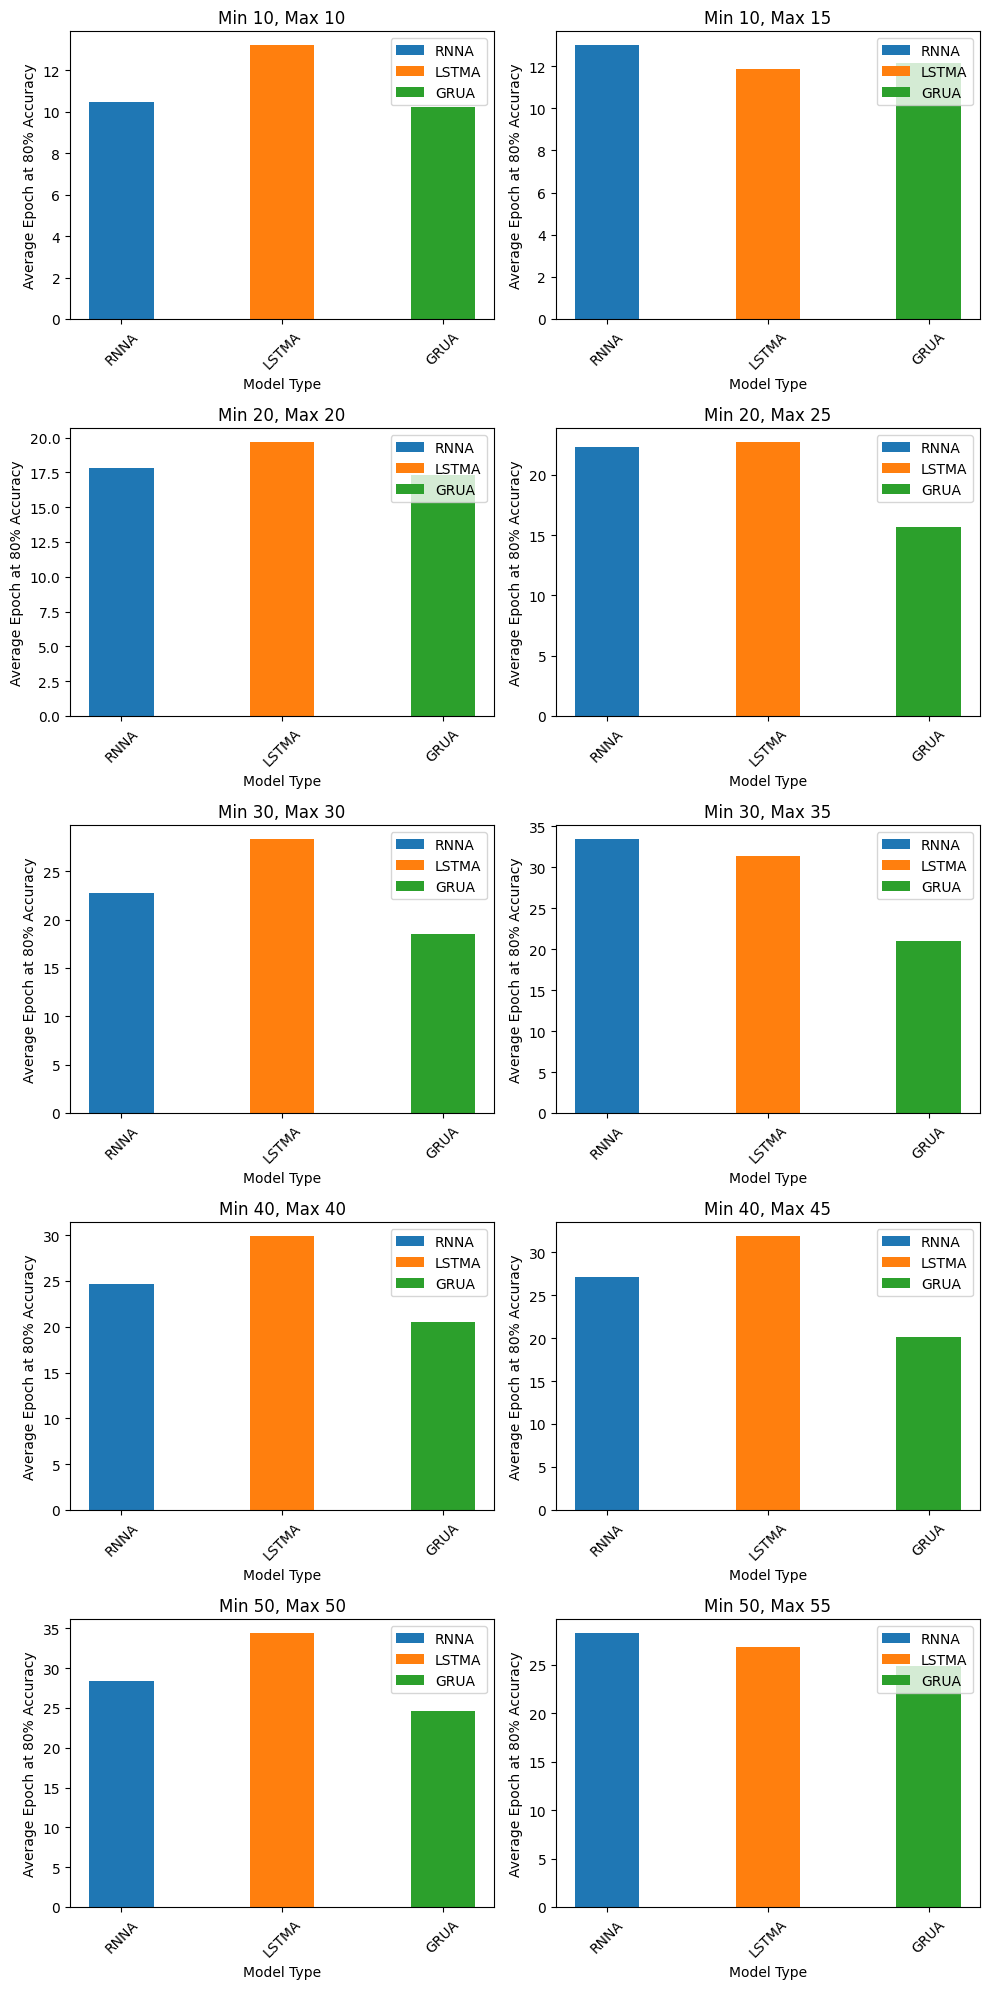

In [81]:
# Constants
kinds = ["RNNA", "LSTMA", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Creating the bar plot
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed

# Create a subplot for each min/max length configuration
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # 5x2 grid for 10 configurations
    bar_positions = np.arange(len(kinds))  # One bar for each model kind

    # Plot the bars
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)

    # Set up the plot
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


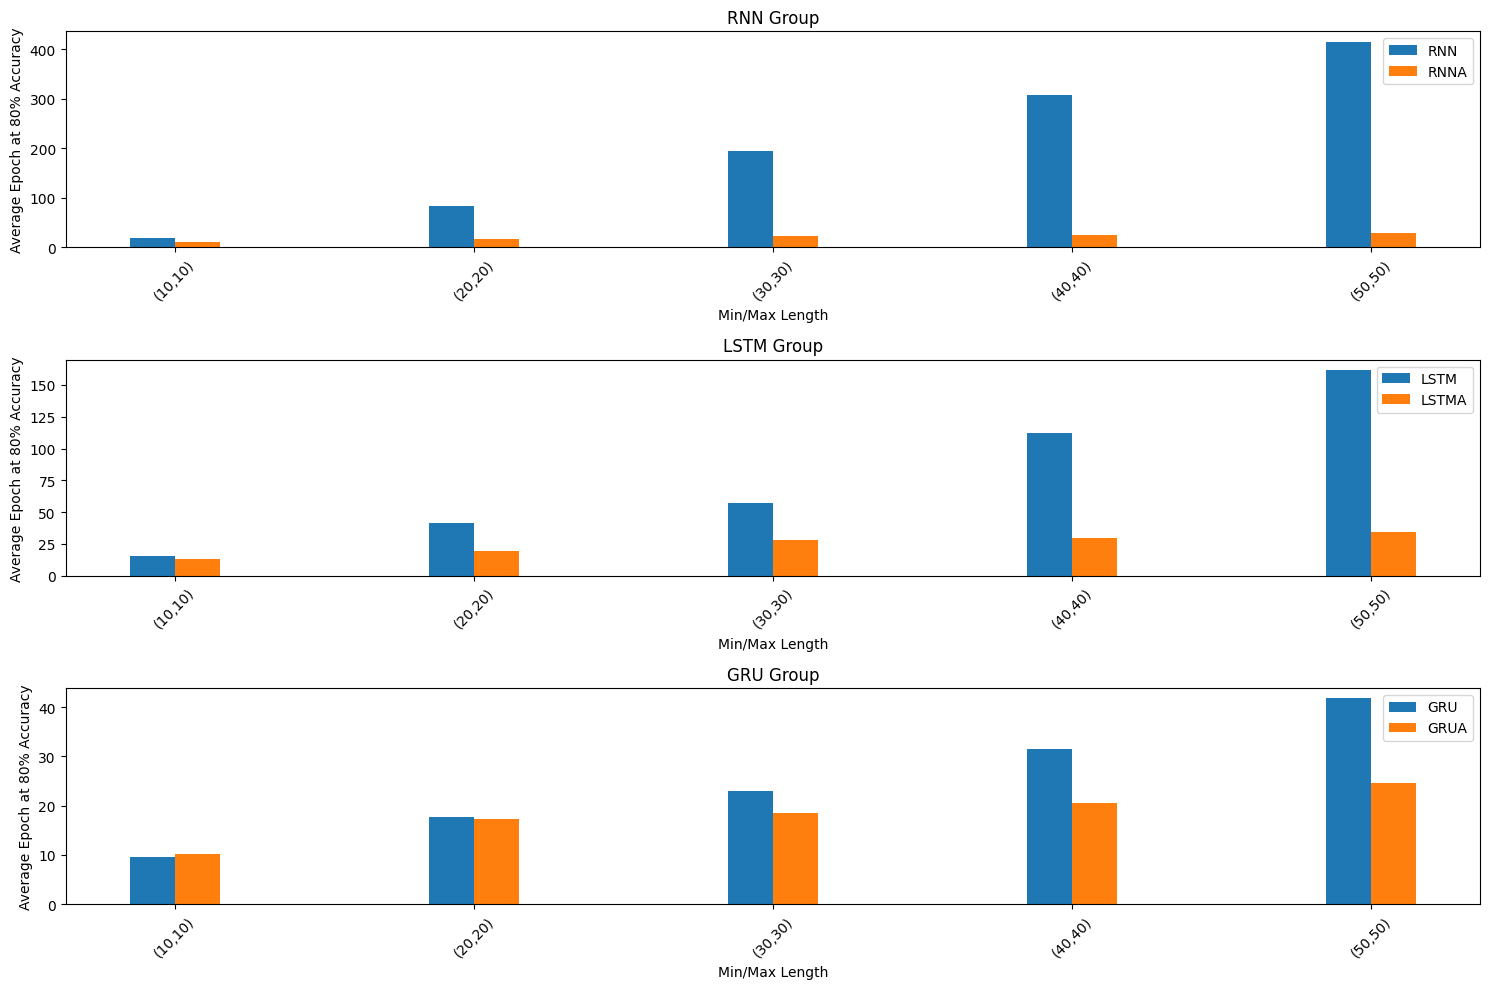

In [82]:
# Model groups
model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [10 ,20, 30, 40, 50]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    if skip_condition(data):
                        continue
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


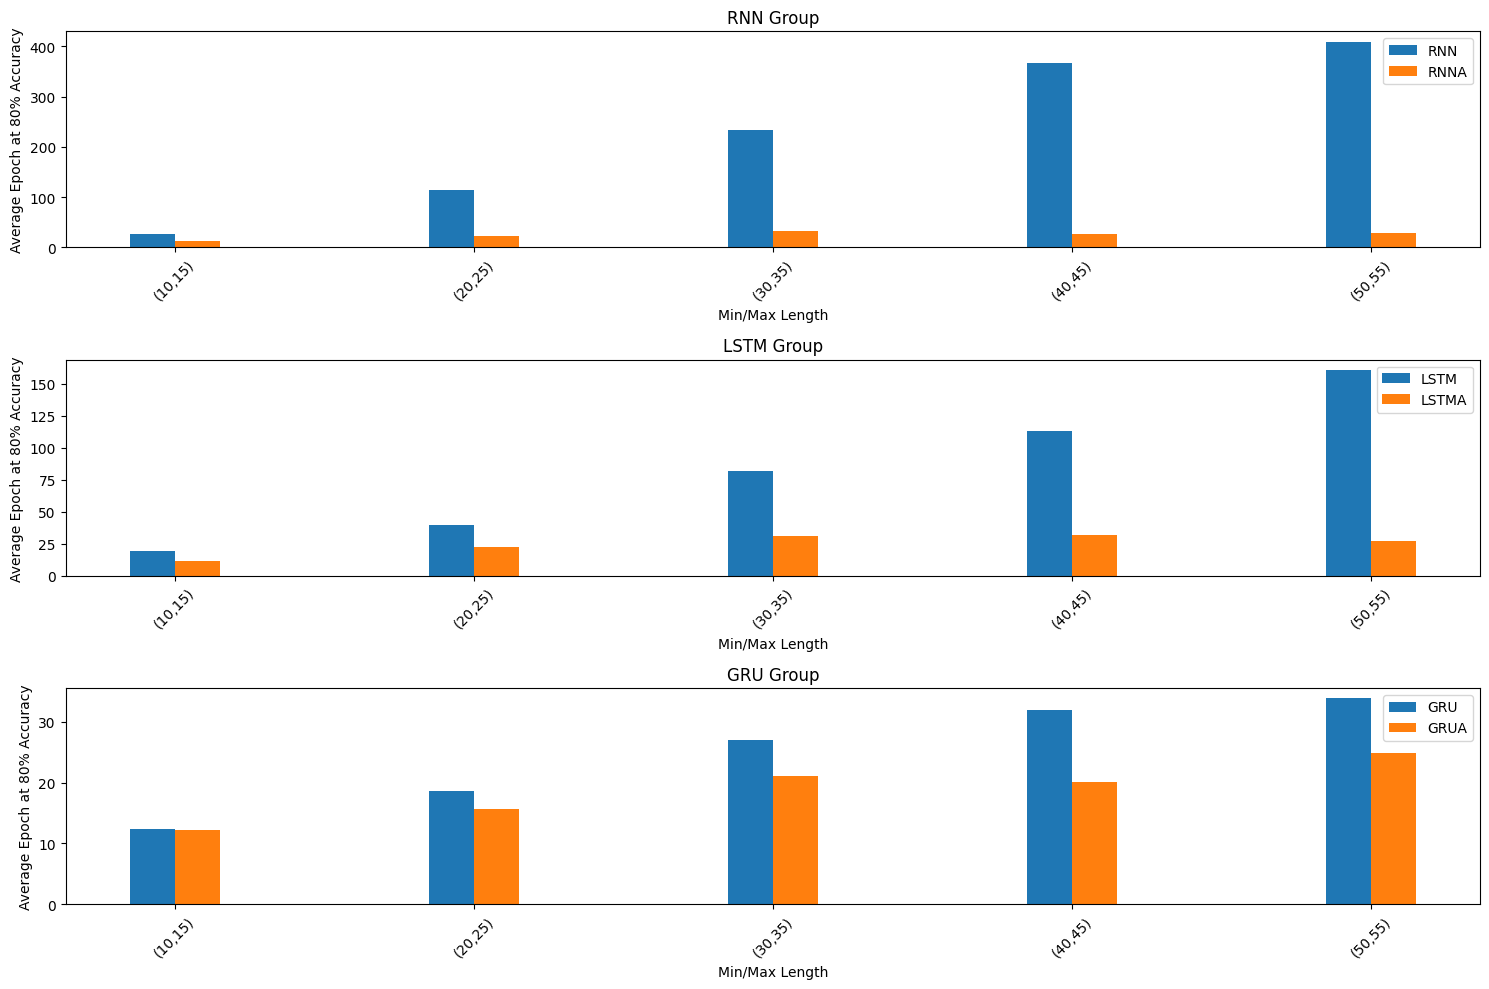

In [83]:
# Model groups
model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [15 ,25, 35, 45, 55]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    if skip_condition(data):
                        continue
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


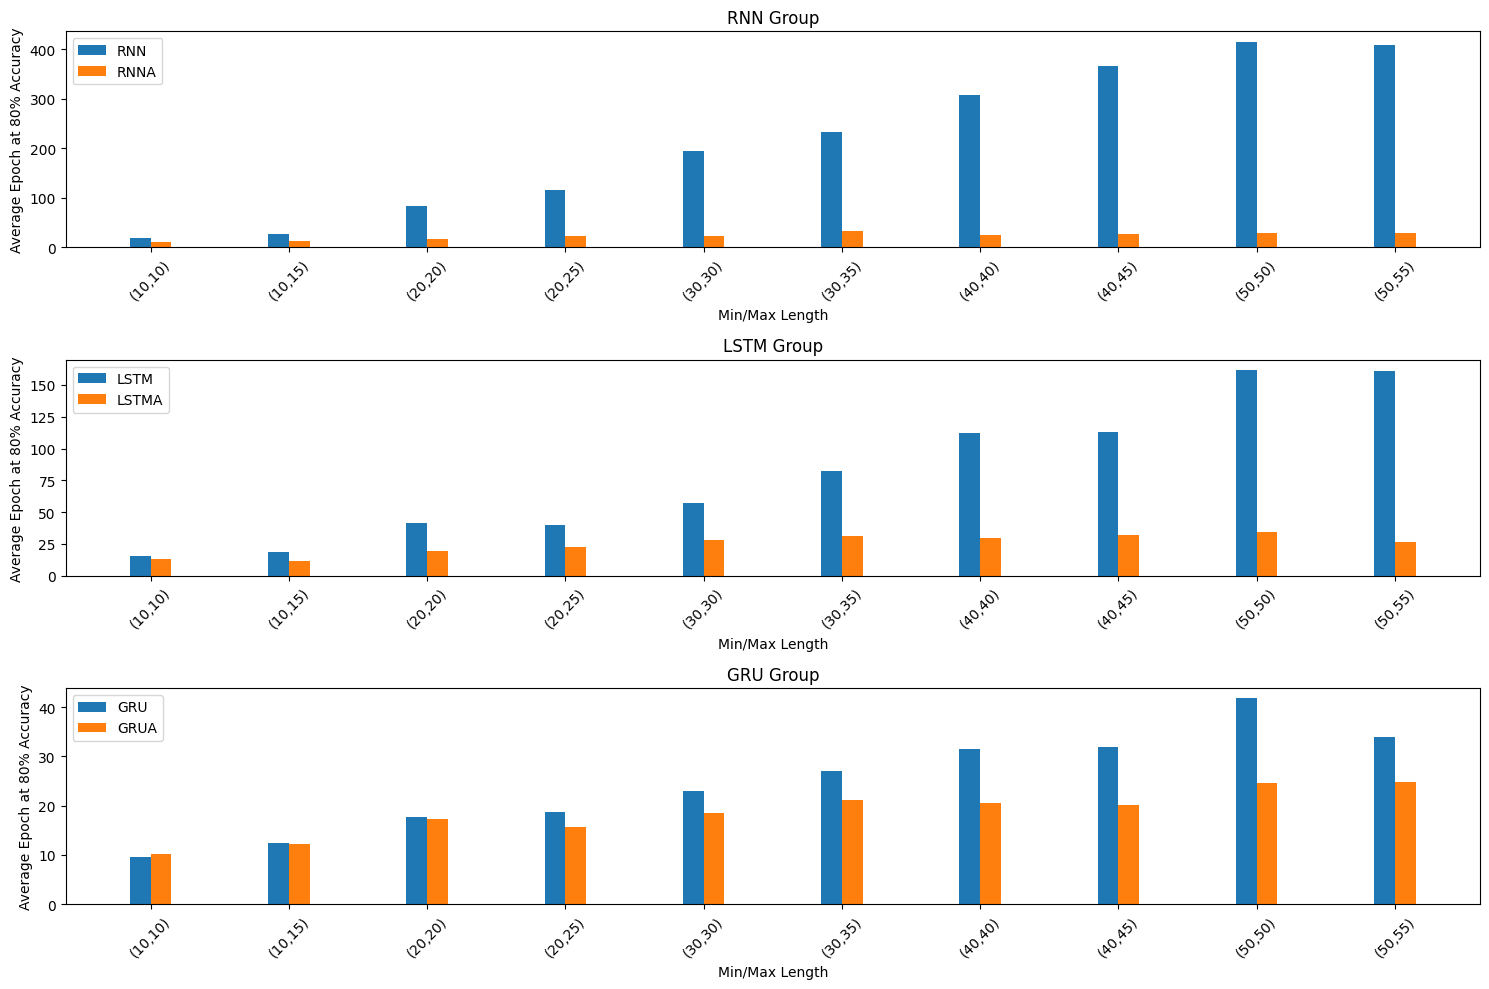

In [84]:
# Model groups
model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    if skip_condition(data):
                        continue
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


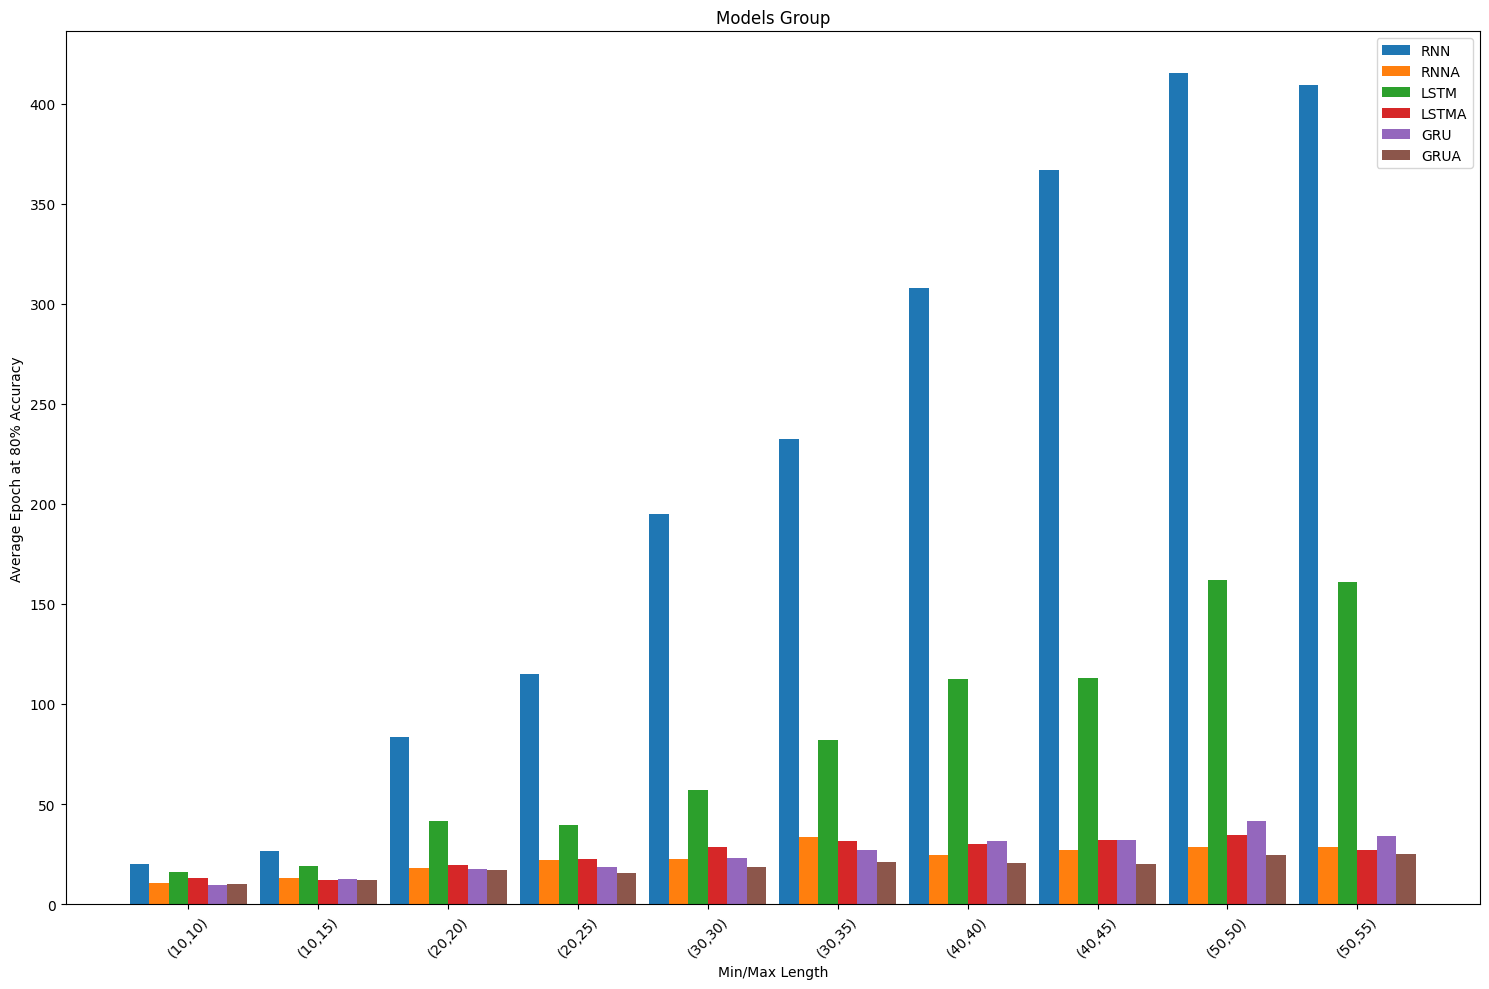

In [125]:
# Model groups
model_groups = {
    "Models": ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA" ],
}

min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    if skip_condition(data):
                        continue
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


# Representation plots


In [10]:
# This function calculates the entropy of a dataset D using the Shannon entropy formula. Entropy is a measure of the unpredictability or randomness of the data.
def symbolEntropy(D, base=2):
    value, counts = numpy.unique(D, return_counts=True)  # Find unique values and their frequency in D
    return entropy(counts, base=base)  # Calculate and return the Shannon entropy

# This function seems to compute a complex metric, possibly related to information theory, involving inputs I, hidden states H, and outputs O.
def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    # Create various combinations of Inputs (I), Hidden states (H), and Outputs (O) for analysis
    # B, IB, AB, BO, IAB, IBO, ABO, IABO are different combinations of I, H, and O
    # Calculate entropy for each combination using symbolEntropy
    # Return a specific information metric combining these entropies


    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

# This function seems to analyze how information is processed or transmitted through a network, focusing on individual components (nodes) of the hidden states H.
def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes = list(range(width))  # Initialize a list of node indices
    cols = []  # To store subsets of nodes
    colh = []  # To store corresponding information values
    # Iteratively remove a node, compute information value, and record subsets and values
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


# This function processes the output of a model given a dataset. It appears to involve some form of clustering (using KMeans) and then re-encoding the hidden states H.
def getOutTaH(model,dataSet):
    O, H = model.step(torch.Tensor(dataSet))  # Get output and hidden states from the model
    # Transform H using clustering and re-encoding

    #print(H.shape,H.min(),H.max())
    #figure()
    #hist(H.flatten())

    H = H.transpose()  # Transpose H for processing
    O = O.transpose()  # Transpose O for processing
    B = numpy.zeros(H.shape)  # Initialize a matrix to store cluster labels for each hidden state
    # Apply KMeans clustering to each hidden state
    # Recompute H as a combination of cluster labels (B)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        x =len(numpy.unique(a))
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

# This function seems to integrate the previous functions to analyze how information flows through the network for different input-output pairs in a dataset.
def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output, H = getOutTaH(model, dataSet)  # Get transformed outputs and hidden states from the model
    # Slice output and H to process only specific timesteps
    output=output.transpose()[whichTS::dsLength].transpose()

    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])

    collectorSet = dict()  # To store information about subsets of nodes (S)
    collectorH = dict()    # To store information values (H)
    # Compute shrinking decomposition information for selected inputs/outputs
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH


# These functions convert the results of the shrinking decomposition into vector and matrix forms, which are likely used for further analysis or visualization.
def removalIntoVec(res,width,H):
    # Convert the shrinking decomposition results into a vector form

    V = numpy.zeros(width)  # Initialize a vector
    # Calculate values for V based on the difference in information values (H) as nodes are removed
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)

    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]

    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    # Convert the shrinking decomposition results into a matrix form

    M=[]
    # Convert the shrinking decomposition results (S and H) into a matrix form
    # This matrix can be used for visualization or further analysis
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

M1 [[ 0.3554909   0.34230451  0.56502876  0.0361142   0.26736921  0.07466616
   0.01104796  0.23492448  0.44361999  0.          0.53747989  0.53747989]
 [ 0.08375256  0.14115303  0.          0.44132113  0.46887001 -0.02216601
   0.46887001  0.46887001  0.14115303  0.44132113 -0.02467967  0.38386651]]


<Figure size 640x480 with 0 Axes>

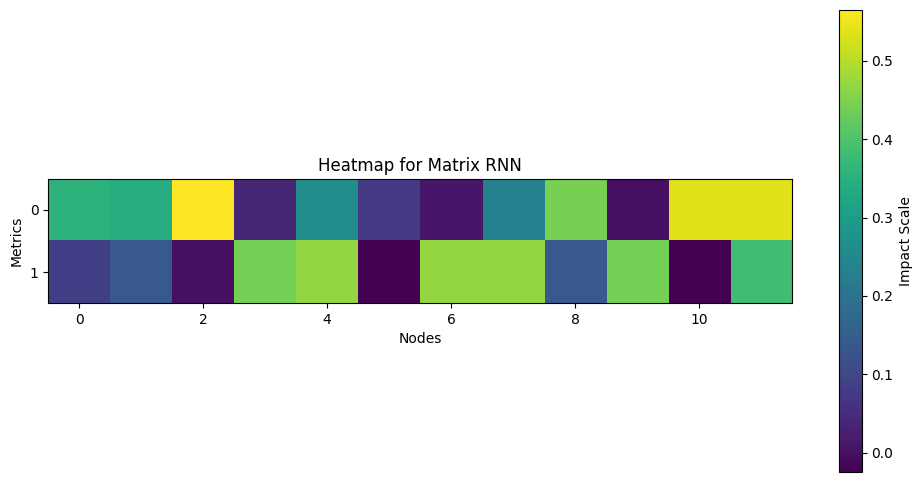

M2 [[ 0.09921413  0.02241519  0.07471761  0.04416248  0.07471761  0.07471761
   0.01844343  0.07471761  0.         -0.00321789  0.09921413  0.07471761]
 [ 0.00108259  0.32560985  0.05835895  0.29541435  0.05835895  0.05835895
   0.32560985  0.05835895  0.06548161  0.23166923  0.          0.05835895]]


<Figure size 640x480 with 0 Axes>

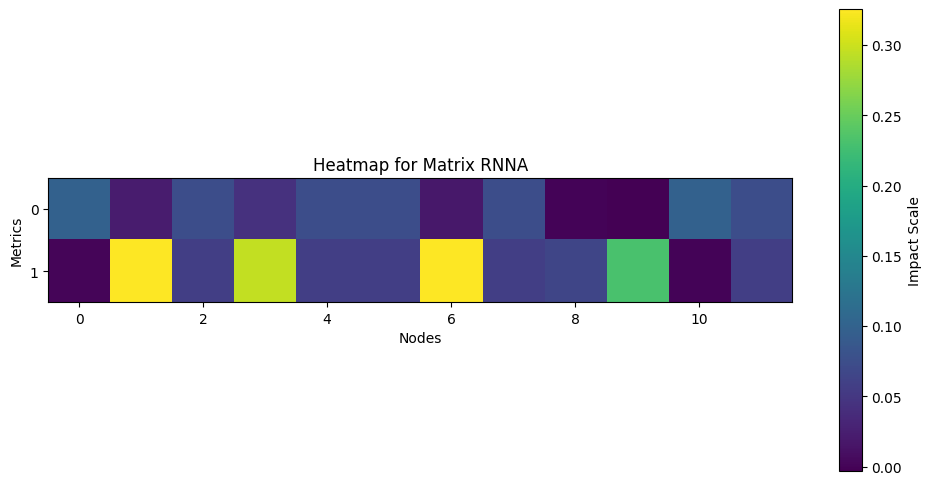

In [38]:
modelRNN=torch.load("./dataModel/model_RNN_min_30_max_35_rep_16.model")
modelRNNWithAttention=torch.load("./dataModel/model_RNNA_min_30_max_35_rep_16.model")
s,t = generateTrainData(100, [30,30])  
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()
M1 = removalIntoMatrix(S,12,H)
print(f"M1 {M1}")
#imshow(M1)
plt.figure(figsize=(12, 6))
plt.imshow(M1)
plt.colorbar(label='Impact Scale')
plt.title('Heatmap for Matrix RNN')
plt.xlabel('Nodes')
plt.ylabel('Metrics')
plt.yticks([0, 1], ['0', '1'])  # Setting y-axis labels to 0 and 1
plt.show()

S,H=shrinkingDecompositionInformation(modelRNNWithAttention,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()

M2 = removalIntoMatrix(S,12,H)
print(f"M2 {M2}")
#imshow(M2)
plt.figure(figsize=(12, 6))
plt.imshow(M2)
plt.colorbar(label='Impact Scale')
plt.title('Heatmap for Matrix RNNA')
plt.xlabel('Nodes')
plt.ylabel('Metrics')
plt.yticks([0, 1], ['0', '1'])  # Setting y-axis labels to 0 and 1
plt.show()

# Calculations

In [88]:
def shannon_entropy(matrix):
    probabilities = matrix.flatten() 
    probabilities = probabilities[probabilities > 0]  # Remove zeros to avoid log(0)
    probabilities = probabilities / probabilities.sum()
    return -np.sum(probabilities * np.log2(probabilities))

In [89]:
def kmeans_thresholding(matrix):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=2, n_init=10).fit(flat_matrix.reshape(-1, 1))

    centroids = kmeans.cluster_centers_.flatten()
    # Determine threshold as the mean of centroids or the higher centroid
    threshold = centroids.mean() if len(centroids) > 1 else centroids[0]

    # Count the number of nodes exceeding the threshold
    count_exceeding = np.sum(flat_matrix > threshold)

    return threshold, count_exceeding

# Apply KMeans thresholding to M1 and M2
threshold_M1, count_exceeding_M1 = kmeans_thresholding(M1)
threshold_M2, count_exceeding_M2 = kmeans_thresholding(M2)

(threshold_M1, count_exceeding_M1, threshold_M2, count_exceeding_M2)

(0.25079848382253744, 13, 0.17259236952506646, 4)

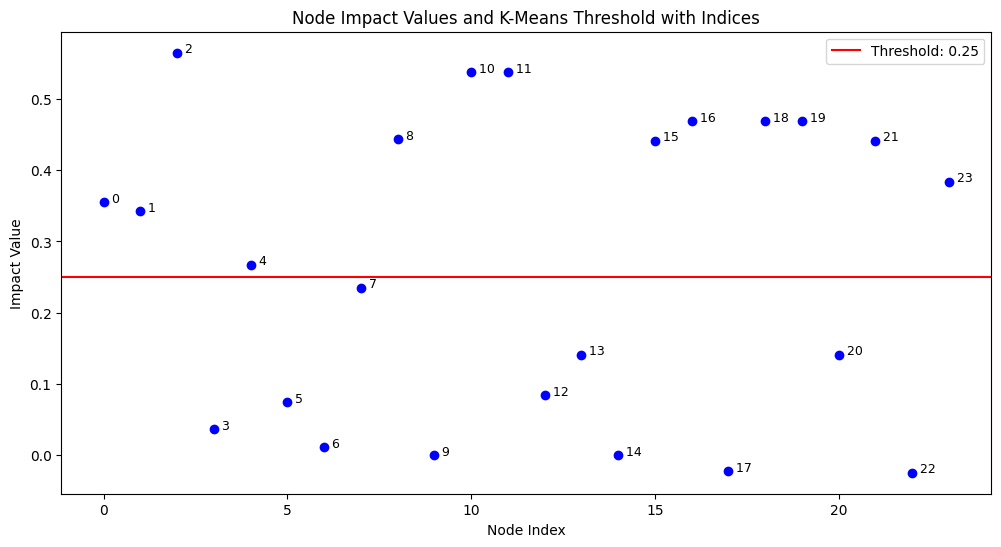

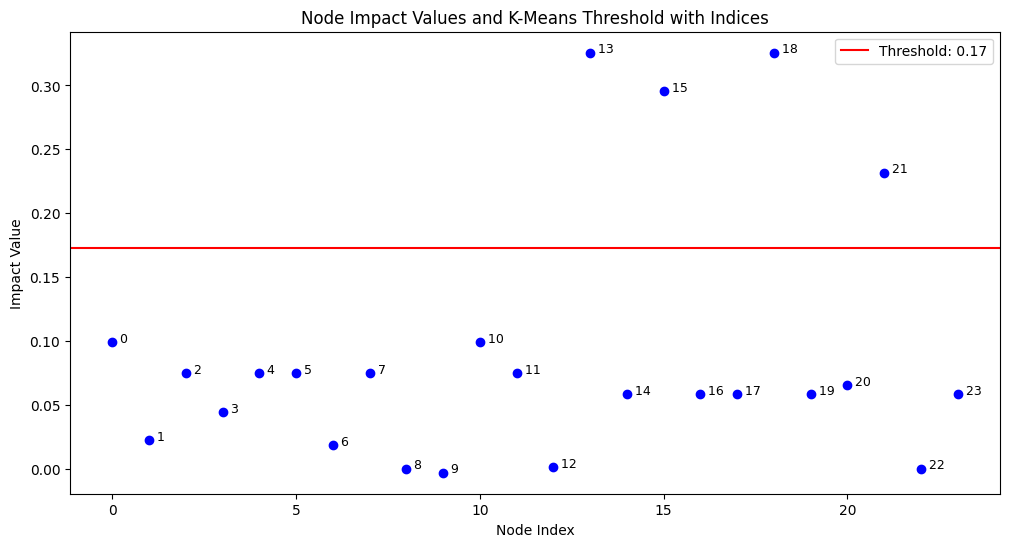

In [90]:
def plot_kmeans_thresholding_with_index(matrix, threshold):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Generate indices for each point in the flattened matrix
    indices = range(len(flat_matrix))

    # Plot the flattened matrix values and the threshold line
    plt.figure(figsize=(12, 6))
    for index, value in zip(indices, flat_matrix):
        plt.scatter(index, value, color='blue')
        #plt.text(index, value, str(index) + " " + str(value), fontsize=9)
        plt.text(index, value, "  " +str(index), fontsize=9)

    plt.axhline(y=threshold, color='red', linestyle='-', label=f'Threshold: {threshold:.2f}')
    plt.xlabel('Node Index')
    plt.ylabel('Impact Value')
    plt.title('Node Impact Values and K-Means Threshold with Indices')
    plt.legend()
    plt.show()

# Apply KMeans thresholding to M1 and M2
threshold_M1, count_exceeding_M1 = kmeans_thresholding(M1)
threshold_M2, count_exceeding_M2 = kmeans_thresholding(M2)

# Plotting for M1 and M2 with indices
plot_kmeans_thresholding_with_index(M1, threshold_M1)
plot_kmeans_thresholding_with_index(M2, threshold_M2)

In [91]:
def threshold_binarize_matrix(matrix, threshold):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply thresholding
    binarized_matrix = np.where(flat_matrix >= threshold, 1, 0)

    # Reshape to the original matrix shape
    binarized_matrix = binarized_matrix.reshape(matrix.shape)

    return binarized_matrix



In [92]:
def calculate_counts(matrix):
    transposed_matrix = matrix.T
    count_11, count_00, count_mixed = 0, 0, 0
    for row in transposed_matrix:
        if np.array_equal(row, [1, 1]):
            count_11 += 1
        elif np.array_equal(row, [0, 0]):
            count_00 += 1
        else:
            count_mixed += 1
    return count_11, count_00, count_mixed

In [93]:
skipped_models

['RNN_min_50_max_50_rep_2', 'RNN_min_50_max_50_rep_25']

In [94]:
from scipy.stats import entropy


# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]  # Assuming you have these types
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31  # Example repetitions, adjust as needed

# Placeholder for the results
results = []

# Gathering data
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        metrics_list = []

        for rep in range(num_reps):
            filename = f"./dataModel/model_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.model"
            model_identifier = f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}'

            try:
                if model_identifier in skipped_models:
                    continue
                # Load the model
                model = torch.load(filename)
                s,t = generateTrainData(100, [min_len,min_len])  
                S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),numbers = [0,1],whichTS=min_len -1,dsLength=min_len)
                # Removal into matrix
                M = removalIntoMatrix(S, 12, H)

                # Calculate metrics
                sum_abs = np.sum(np.abs(M))
                mean = np.mean(M)
                std = np.std(M)
                entropy_s = shannon_entropy(M)
                max_val = np.max(M)
                min_val = np.min(M)
                threshold, count_exceeding = kmeans_thresholding(M)
                binarized_matrix = np.where(M.flatten() >= threshold, 1, 0).reshape(M.shape)
                count_11, count_00, count_mixed = calculate_counts(binarized_matrix)
                ratio_11_00_mixed = count_11 / (count_mixed + count_00) if (count_mixed + count_00) != 0 else 0
                ratio_11_mixed = count_11 / count_mixed if count_mixed != 0 else 0

                metrics = {
                    "Kind": kind,
                    "Min_Length": min_len,
                    "Max_Length": max_len,
                    "Repetition": rep,
                    "Sum of Absolute Values": sum_abs,
                    "Mean Value": mean,
                    "Standard Deviation": std,
                    "Maximum Value": max_val,
                    "Minimum Value": min_val,
                    "Shannon Entropy": entropy_s,
                    "Kmeans Threshold": threshold,
                    "Kmeans Nodes Exceeding": count_exceeding,
                    "Overlap with zeroes": ratio_11_00_mixed,
                    "Overlap no zeroes": ratio_11_mixed
                }

                # Append this dictionary to the results list
                results.append(metrics)

            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

df = pd.DataFrame(results)
df

Kind  Min_Length  Max_Length  Repetition  Sum of Absolute Values  \
0      RNN          10          10           0                8.797239   
1      RNN          10          10           1                9.933641   
2      RNN          10          10           2                9.432540   
3      RNN          10          10           3                9.643067   
4      RNN          10          10           4                9.036820   
...    ...         ...         ...         ...                     ...   
1853  GRUA          50          55          26                6.482852   
1854  GRUA          50          55          27                7.162548   
1855  GRUA          50          55          28                7.837131   
1856  GRUA          50          55          29                5.693859   
1857  GRUA          50          55          30                5.155258   

      Mean Value  Standard Deviation  Maximum Value  Minimum Value  \
0       0.366552            0.353837       0.985809       0.000000   
1       0.413395            0.316928       0.982029      -0.006077   
2       0.393023            0.321506       0.979697       0.000000   
3       0.394607            0.332375       0.991804      -0.048583   
4       0.370934            0.337962       0.991226      -0.022402   
...          ...                 ...            ...            ...   
1853    0.268168            0.244162       0.649856      -0.014266   
1854    0.297800            0.230403       0.650167      -0.003839   
1855    0.323422            0.209077       0.570755      -0.021111   
1856    0.231675            0.202153       0.510807      -0.030266   
1857    0.214715            0.189882       0.506113      -0.001053   

      Shannon Entropy  Kmeans Threshold  Kmeans Nodes Exceeding  \
0            3.845547          0.514334                       7   
1            4.077288          0.367512                      14   
2            4.012344          0.347705                      14   
3            3.982893          0.322481                      15   
4            3.922352          0.505363                       7   
...               ...               ...                     ...   
1853         3.879172          0.324068                       9   
1854         4.066632          0.412780                       6   
1855         4.169034          0.307966                      13   
1856         3.922532          0.246947                      11   
1857         3.919082          0.243129                      10   

      Overlap with zeroes  Overlap no zeroes  
0                0.000000           0.000000  
1                0.500000           0.666667  
2                0.333333           0.375000  
3                0.714286           1.000000  
4                0.000000           0.000000  
...                   ...                ...  
1853             0.000000           0.000000  
1854             0.000000           0.000000  
1855             0.714286           1.666667  
1856             0.090909           0.111111  
1857             0.090909           0.125000  

[1858 rows x 14 columns]

In [95]:
df.to_csv("results1.csv")

In [96]:
# Now, calculating the average for each kind_min_max
average_results = df.groupby(['Kind', 'Min_Length', 'Max_Length']).mean().reset_index()

# Display the averaged results
average_results

Kind  Min_Length  Max_Length  Repetition  Sum of Absolute Values  \
0     GRU          10          10   15.000000                9.169252   
1     GRU          10          15   15.000000                9.255019   
2     GRU          20          20   15.000000                8.089622   
3     GRU          20          25   15.000000                8.129597   
4     GRU          30          30   15.000000                7.644638   
5     GRU          30          35   15.000000                7.906421   
6     GRU          40          40   15.000000                7.196111   
7     GRU          40          45   15.000000                7.080696   
8     GRU          50          50   15.000000                6.219858   
9     GRU          50          55   15.000000                6.046265   
10   GRUA          10          10   15.000000                9.229252   
11   GRUA          10          15   15.000000                9.287008   
12   GRUA          20          20   15.000000                8.123585   
13   GRUA          20          25   15.000000                8.147264   
14   GRUA          30          30   15.000000                7.867508   
15   GRUA          30          35   15.000000                7.998214   
16   GRUA          40          40   15.000000                6.846238   
17   GRUA          40          45   15.000000                6.885930   
18   GRUA          50          50   15.000000                6.120122   
19   GRUA          50          55   15.000000                6.404489   
20   LSTM          10          10   15.000000                9.099763   
21   LSTM          10          15   15.000000                9.182514   
22   LSTM          20          20   15.000000                8.145213   
23   LSTM          20          25   15.000000                7.942190   
24   LSTM          30          30   15.000000                7.885408   
25   LSTM          30          35   15.000000                8.010104   
26   LSTM          40          40   15.000000                6.791216   
27   LSTM          40          45   15.000000                7.323910   
28   LSTM          50          50   15.000000                6.303715   
29   LSTM          50          55   15.000000                5.756990   
30  LSTMA          10          10   15.000000                9.353586   
31  LSTMA          10          15   15.000000                9.300088   
32  LSTMA          20          20   15.000000                8.194980   
33  LSTMA          20          25   15.000000                8.006072   
34  LSTMA          30          30   15.000000                7.758756   
35  LSTMA          30          35   15.000000                8.137122   
36  LSTMA          40          40   15.000000                6.958947   
37  LSTMA          40          45   15.000000                6.735160   
38  LSTMA          50          50   15.000000                6.313173   
39  LSTMA          50          55   15.000000                6.308494   
40    RNN          10          10   15.000000                9.215577   
41    RNN          10          15   15.000000                9.298727   
42    RNN          20          20   15.000000                7.937626   
43    RNN          20          25   15.000000                8.120190   
44    RNN          30          30   15.000000                8.004070   
45    RNN          30          35   15.000000                7.834058   
46    RNN          40          40   15.000000                6.999846   
47    RNN          40          45   15.000000                6.949815   
48    RNN          50          50   15.103448                6.219642   
49    RNN          50          55   15.000000                6.190243   
50   RNNA          10          10   15.000000                9.230757   
51   RNNA          10          15   15.000000                9.259482   
52   RNNA          20          20   15.000000                8.054963   
53   RNNA          20          25   15.000000                8.

In [97]:
average_results.to_csv("average_results.csv")

In [98]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]  # Assuming you have these types
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31  # Number of repetitions for matrix generation

# Placeholder for the results
results = []

# Gathering data
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        # Initialize an array to store matrices
        matrices = []
        for rep in range(num_reps):
            filename = f"./dataModel/model_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.model"
            try:
                # Load the model
                model = torch.load(filename)

            
                s, t = generateTrainData(100, [min_len, min_len])  
                S, H = shrinkingDecompositionInformation(model, 12, s, t.transpose(), numbers=[0, 1], whichTS=min_len - 1, dsLength=min_len)
                M = removalIntoMatrix(S, 12, H)
                matrices.append(M)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue
        # Compute the average matrix
        avg_M = np.mean(matrices, axis=0)

        # Calculate metrics based on the average matrix
        sum_abs = np.sum(np.abs(avg_M))
        mean = np.mean(avg_M)
        std = np.std(avg_M)
        entropy_s = shannon_entropy(avg_M)
        max_val = np.max(avg_M)
        min_val = np.min(avg_M)
        threshold, count_exceeding = kmeans_thresholding(avg_M)
        binarized_matrix = np.where(avg_M.flatten() >= threshold, 1, 0).reshape(avg_M.shape)
        count_11, count_00, count_mixed = calculate_counts(binarized_matrix)
        ratio_11_00_mixed = count_11 / (count_mixed + count_00) if (count_mixed + count_00) != 0 else 0
        ratio_11_mixed = count_11 / count_mixed if count_mixed != 0 else 0

        metrics = {
            "Kind": kind,
            "Min_Length": min_len,
            "Max_Length": max_len,
            "Sum of Absolute Values": sum_abs,
            "Mean Value": mean,
            "Standard Deviation": std,
            "Maximum Value": max_val,
            "Minimum Value": min_val,
            "Shannon Entropy": entropy_s,
            "Kmeans Threshold": threshold,
            "Kmeans Nodes Exceeding": count_exceeding,
            "Overlap with zeroes": ratio_11_00_mixed,
            "Overlap no zeroes": ratio_11_mixed
        }

        # Append this dictionary to the results list
        results.append(metrics)


# Create a DataFrame from the results list
df1 = pd.DataFrame(results)
df1


Kind  Min_Length  Max_Length  Sum of Absolute Values  Mean Value  \
0     RNN          10          10                9.717596    0.404900   
1    RNNA          10          10                5.217355    0.217390   
2    LSTM          10          10               11.247847    0.468660   
3   LSTMA          10          10                4.197414    0.174892   
4     GRU          10          10               12.549105    0.522879   
5    GRUA          10          10                4.392211    0.183009   
6     RNN          10          15               10.081906    0.420079   
7    RNNA          10          15                6.152972    0.256374   
8    LSTM          10          15               10.940889    0.455870   
9   LSTMA          10          15                5.104706    0.212696   
10    GRU          10          15               12.993731    0.541405   
11   GRUA          10          15                3.685243    0.153552   
12    RNN          20          20               10.645079    0.443545   
13   RNNA          20          20                2.346789    0.097783   
14   LSTM          20          20               10.327331    0.430305   
15  LSTMA          20          20                1.661354    0.069223   
16    GRU          20          20               12.726983    0.530291   
17   GRUA          20          20                2.830270    0.117928   
18    RNN          20          25               10.607637    0.441985   
19   RNNA          20          25                2.377860    0.099078   
20   LSTM          20          25               10.574029    0.440585   
21  LSTMA          20          25                1.907666    0.079486   
22    GRU          20          25               12.417351    0.517390   
23   GRUA          20          25                1.912277    0.079678   
24    RNN          30          30               11.164093    0.465171   
25   RNNA          30          30                1.363920    0.056830   
26   LSTM          30          30               10.507950    0.437831   
27  LSTMA          30          30                0.948714    0.039530   
28    GRU          30          30               12.912440    0.538018   
29   GRUA          30          30                1.295419    0.053976   
30    RNN          30          35               11.026214    0.459426   
31   RNNA          30          35                1.329661    0.055403   
32   LSTM          30          35               10.669575    0.444566   
33  LSTMA          30          35                0.555076    0.023128   
34    GRU          30          35               12.688973    0.528707   
35   GRUA          30          35                1.578439    0.065768   
36    RNN          40          40               11.459360    0.477473   
37   RNNA          40          40                1.537424    0.064059   
38   LSTM          40          40               10.420758    0.434198   
39  LSTMA          40          40                0.625283    0.026053   
40    GRU          40          40               12.669899    0.527912   
41   GRUA          40          40                1.287576    0.053649   
42    RNN          40          45               11.154314    0.464763   
43   RNNA          40          45                0.850702    0.035446   
44   LSTM          40          45               10.227301    0.426138   
45  LSTMA          40          45                0.811855    0.033827   
46    GRU          40          45               12.137137    0.505714   
47   GRUA          40          45                0.788095    0.032837   
48    RNN          50          50               11.068543    0.461189   
49   RNNA          50          50                0.869103    0.036213   
50   LSTM          50          50               10.664140    0.444339   
51  LSTMA          50          50                0.266304    0.011092   
52    GRU          50          50               12.848492    0.535354   
53   GRUA          50          50                0.939049    0.

In [99]:
df1.to_csv("df1.csv")